## Diabetes Prediction Dataset

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.cm as cm 
import seaborn as sns 
import lightgbm 
import warnings 
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression, SGDClassifier
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix, plot_confusion_matrix, accuracy_score, precision_score, recall_score, classification_report, mutual_info_score, roc_auc_score, f1_score, make_scorer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn import svm 
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans 
from sklearn.decomposition import PCA 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
import xgboost as xgb
from catboost import CatBoostClassifier
import plotly.express as px 
import plotly.offline as plot 
import random 
import statsmodels.api as sm 
import os 
import missingno as msno 


warnings.simplefilter('ignore')
%matplotlib inline 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier

In [ ]:
!pip install xgboost

In [ ]:
#!pip install catboost

## Exploratory Data Analysis (EDA) 

### Initial cleaning and reformating of the dataset 

In [3]:
diabetes = pd.read_csv('https://raw.githubusercontent.com/cindym02/DiabeticData/main/diabetic_data.csv')
diabetes.head(5)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [4]:
def nans (i):
    print('The total length of this dataset is ', len(i), '.', sep='')
    print('The total number of ?s within this dataset is ', len(i[(i == '?').any(axis=1)]), '.', sep='')
    i.race.replace('?', 'Other', inplace = True)
    i.gender.replace('Unknown/Invalid', 'Other', inplace = True)
    i.medical_specialty.replace('Physician Not Found', 'NaN', inplace = True)
    i.replace('?', 'NaN', inplace = True)
    print('Post initial cleaning, the total number of rows with NaNs within this dataset is ', len(i[(i == 'NaN').any(axis=1)]), '.', sep='')
    print('Post initial cleaning, the total number of rows without NaNs within this dataset is ', len(i[~(i == 'NaN').any(axis=1)]), '.', sep='')

nans(diabetes)

The total length of this dataset is 101766.
The total number of ?s within this dataset is 100723.
Post initial cleaning, the total number of rows with NaNs within this dataset is 100681.
Post initial cleaning, the total number of rows without NaNs within this dataset is 1085.


In [5]:
t = diabetes['race'].to_list()
print(f'Original:\n{random.sample(t, 50)}')
     #print('the original list:\n' + str(t))

res = []
for ele in t: 
    temp = [[]]
    
    for char in ele: 
        if char.isupper():
            temp.append([]) 
        temp[-1].append(char)
    res.append(' '.join(''.join(ele) for ele in temp).strip())
diabetes.race = res
 
#print('the modified list:\n' + str(res))
print(f'Modified:\n{diabetes.race.value_counts()}')

Original:
['Caucasian', 'Caucasian', 'Caucasian', 'Caucasian', 'Caucasian', 'Other', 'Caucasian', 'Caucasian', 'Caucasian', 'Caucasian', 'Caucasian', 'Caucasian', 'AfricanAmerican', 'AfricanAmerican', 'AfricanAmerican', 'AfricanAmerican', 'Caucasian', 'Caucasian', 'Caucasian', 'Caucasian', 'Caucasian', 'Caucasian', 'Caucasian', 'Asian', 'AfricanAmerican', 'Caucasian', 'Caucasian', 'Caucasian', 'Caucasian', 'Caucasian', 'Caucasian', 'AfricanAmerican', 'AfricanAmerican', 'Caucasian', 'AfricanAmerican', 'Other', 'Caucasian', 'Caucasian', 'Caucasian', 'Caucasian', 'AfricanAmerican', 'Caucasian', 'AfricanAmerican', 'Caucasian', 'Caucasian', 'AfricanAmerican', 'Caucasian', 'Caucasian', 'AfricanAmerican', 'Caucasian']
Modified:
Caucasian           76099
African American    19210
Other                3779
Hispanic             2037
Asian                 641
Name: race, dtype: int64


In [6]:
def mod_age (data):     
     for i in range(diabetes.shape[0]):
          if (diabetes.loc[i,'age']=='[70-80)'):
               diabetes.loc[i,'age']=random.randint(70, 79)
          elif (diabetes.loc[i,'age']=='[60-70)'):
               diabetes.loc[i,'age']= random.randint(60,69)
          elif (diabetes.loc[i,'age']=='[50-60)'):
               diabetes.loc[i,'age']= random.randint(50, 59)
          elif (diabetes.loc[i,'age']=='[80-90)'):
               diabetes.loc[i,'age']=  random.randint(80, 89)
          elif (diabetes.loc[i,'age']=='[40-50)'):
               diabetes.loc[i,'age']=random.randint(40, 49)
          elif (diabetes.loc[i,'age']=='[30-40)'):
               diabetes.loc[i,'age']=random.randint(30, 39)
          elif (diabetes.loc[i,'age']=='[90-100)'):
               diabetes.loc[i,'age']=random.randint(90, 99)
          elif (diabetes.loc[i,'age']=='[20-30)'):
               diabetes.loc[i,'age']=random.randint(20, 29)
          elif (diabetes.loc[i,'age']=='[10-20)'):
               diabetes.loc[i,'age']= random.randint(10, 19) 
          elif (diabetes.loc[i,'age']=='[0-10)'):
               diabetes.loc[i,'age']= random.randint(1, 9)
     return data 

mod_age(diabetes)
diabetes.age.astype(int)
print(diabetes.age.value_counts())

79    2648
75    2636
74    2636
77    2622
73    2614
      ... 
1       17
8       16
7       15
4       14
6       12
Name: age, Length: 99, dtype: int64


In [7]:
print(f'Prior to grouping and encoding the dataset for binary classification:\n{diabetes.readmitted.value_counts()}')
yes = ['>30', '<30']
diabetes.loc[diabetes['readmitted'].isin(yes), 'readmitted'] = 'YES'
print(f'Post grouping and prepping the dataset for binary classification:\n{diabetes.readmitted.value_counts()}')

Prior to grouping and encoding the dataset for binary classification:
NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64
Post grouping and prepping the dataset for binary classification:
NO     54864
YES    46902
Name: readmitted, dtype: int64


##### Exporting the modified dataset for visualizing EDA within Tableau 

In [8]:
'''import os 
os.chdir('/Users/INSERT_HERE')
path = os.getcwd()
diabetes.to_csv(path + '/Desktop/visual_diabetic_data.csv', encoding = 'utf-8' )'''

"import os \nos.chdir('/Users/INSERT_HERE')\npath = os.getcwd()\ndiabetes.to_csv(path + '/Desktop/visual_diabetic_data.csv', encoding = 'utf-8' )"

### Visualizing the distribution and performing bivariate analyses 

In [ ]:
x = diabetes['readmitted']
ax = sns.countplot(x=x, data = diabetes).set(title = 'Diabetes Readmission Rates')
y = diabetes['readmitted']
print(f'Percentage of patients that HAD been readmitted: {round(y.value_counts(normalize=True)[1]*100,2)}% --> ({y.value_counts()[1]} patient')
print(f'Percentage of patients that HAD NOT been readmitted: {round(y.value_counts(normalize=True)[0]*100,2)}% --> ({y.value_counts()[0]} patient)')

In [10]:
def missing (i):
    i.replace('NaN', np.nan, inplace = True) #replace previous 'nan' with np.nan for coutning missing values  
    missing_number = i.isnull().sum().sort_values(ascending=False).to_frame()
    missing_percent = (i.isnull().sum()/i.isnull().count()).sort_values(ascending=False).round(3).to_frame()
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    missing_values['Missing_Percent'] = missing_values["Missing_Percent"]*100
    return missing_values

missing_values = missing(diabetes)
missing_values

,Missing_Number,Missing_Percent
,0,0
weight,98569,96.9
medical_specialty,49949,49.1
payer_code,40256,39.6
diag_3,1423,1.4
diag_2,358,0.4
diag_1,21,0.0
encounter_id,0,0.0
troglitazone,0,0.0
glipizide,0,0.0


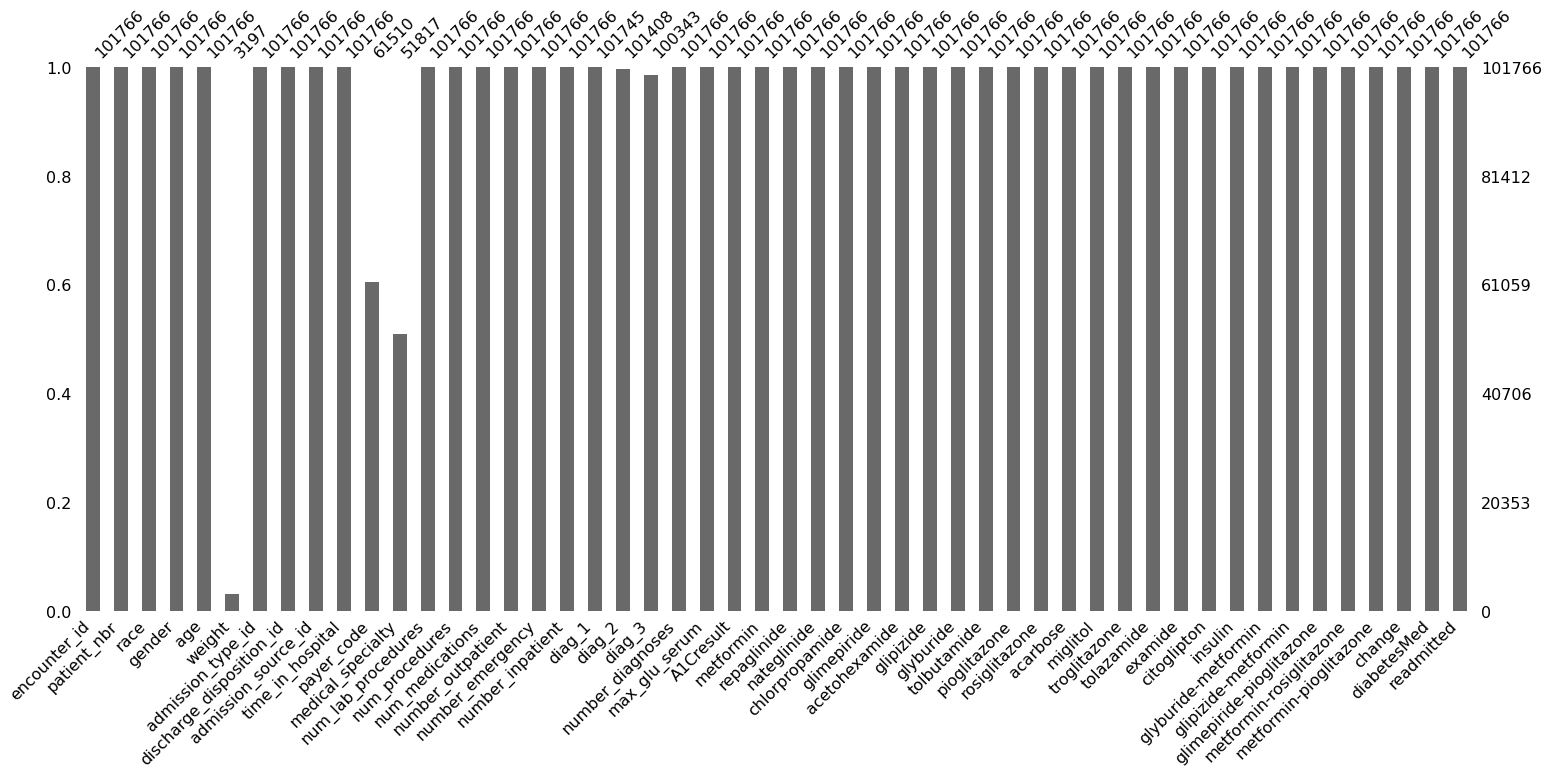

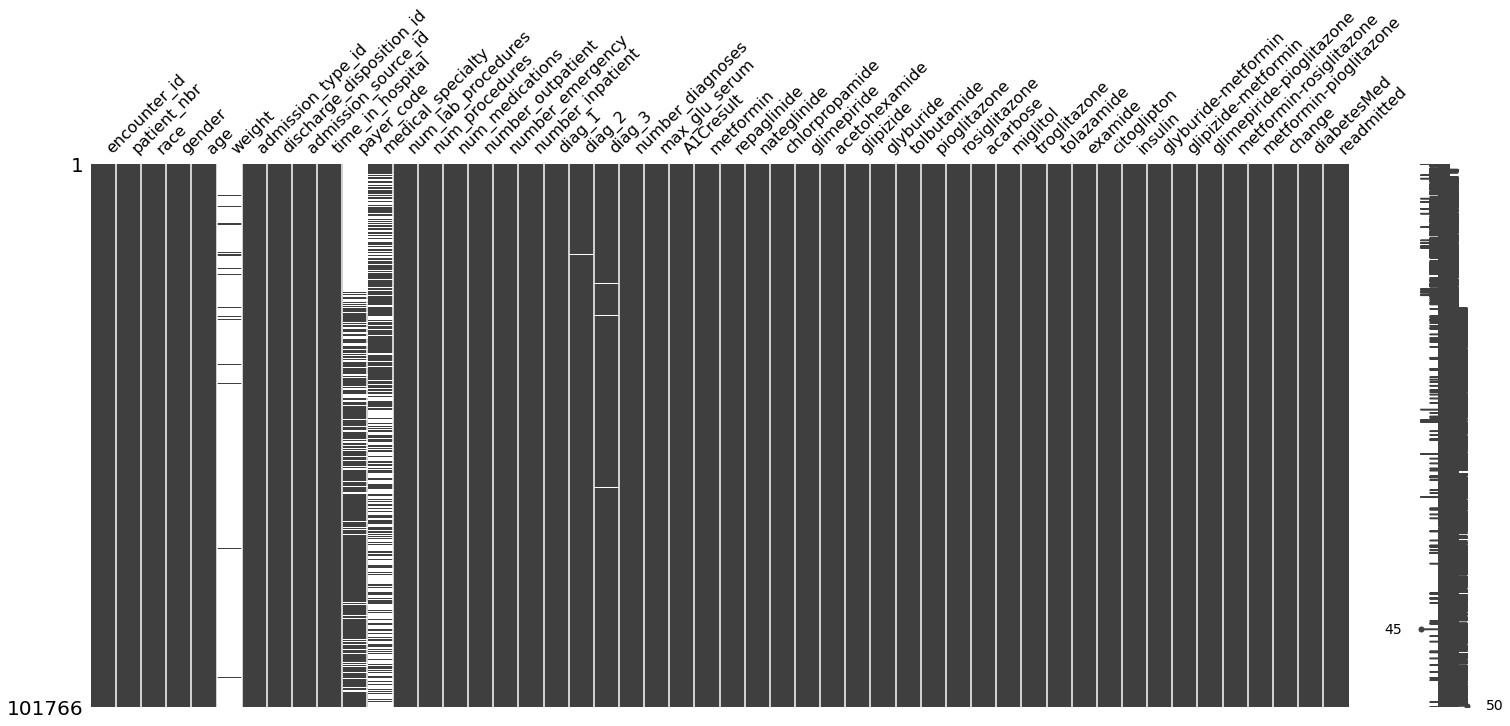

In [11]:
msno.bar(diabetes)
msno.matrix(diabetes)

In [12]:
num = list(diabetes.select_dtypes(['int64']).columns)
num_exclude = ['encounter_id', 'patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id']
num_cleaned = [x for x in num if x not in num_exclude]
cat = list(diabetes.select_dtypes(['object']).columns)
#cat_exclude = ['max_glu_serum', 'A1Cresult', 'metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol','troglitazone','tolazamide','examide','citoglipton','insulin','glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone','change']
#cat_cleaned = [x for x in cat if x not in cat_exclude]

num = list(diabetes.select_dtypes(['int64']).columns)
num_exclude = ['encounter_id', 'patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id']
num_cleaned = [x for x in num if x not in num_exclude]
cat = list(diabetes.select_dtypes(['object']).columns)
cat_exclude = ['max_glu_serum', 'A1Cresult', 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'citoglipton',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'change']
cat_cleaned = [x for x in cat if x not in cat_exclude]

In [13]:
print(f'The columns within num_cleaned are:\n{num_cleaned}')
print(f'The columns within cat_cleaned are:\n {cat}')

The columns within num_cleaned are:
['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']
The columns within cat_cleaned are:
 ['race', 'gender', 'weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted']


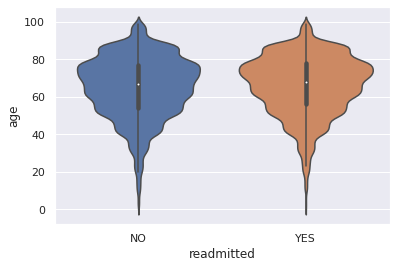

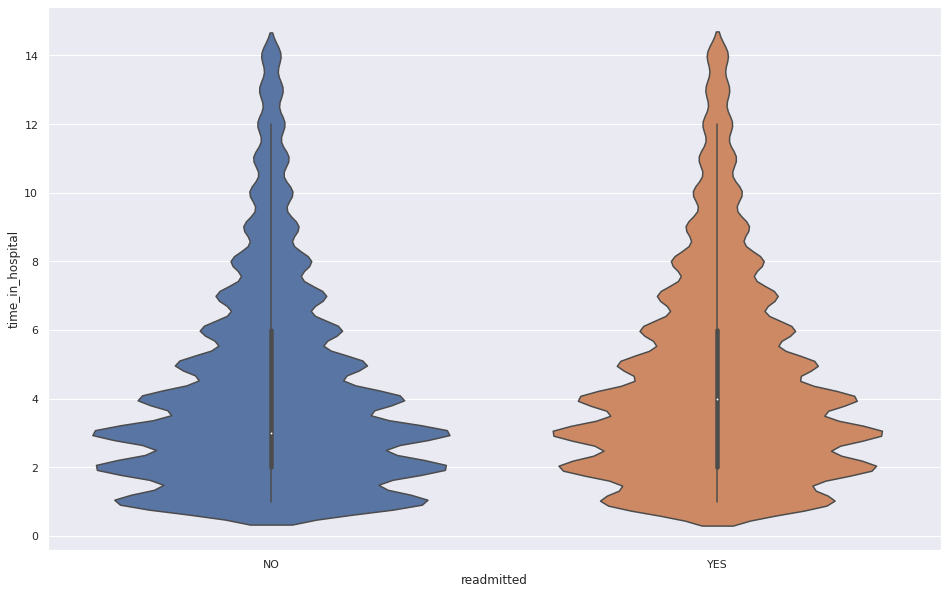

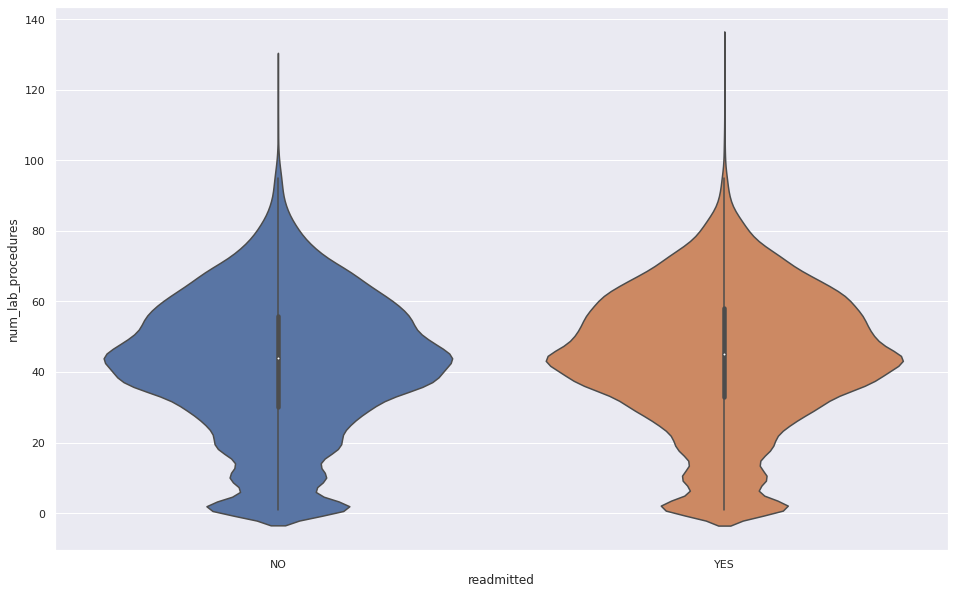

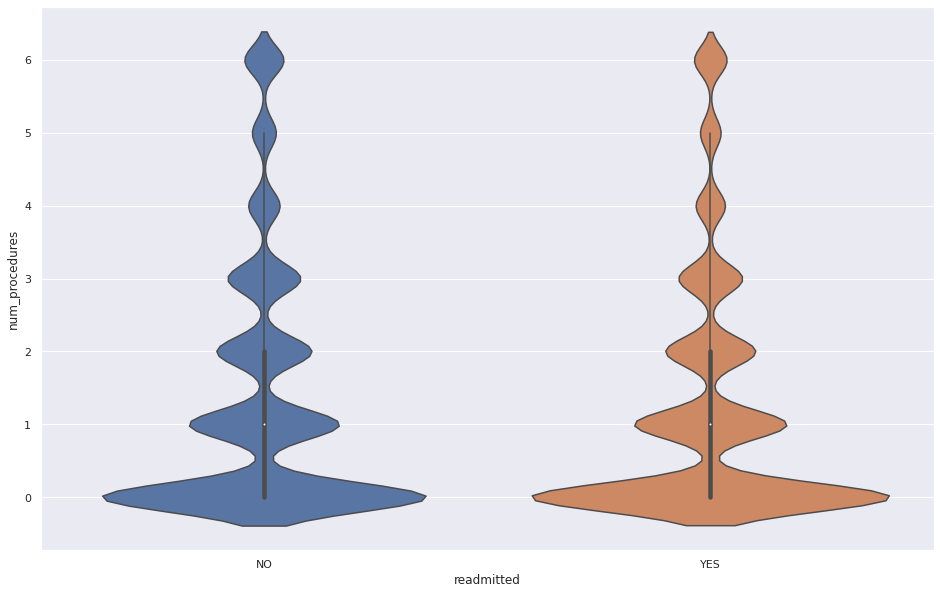

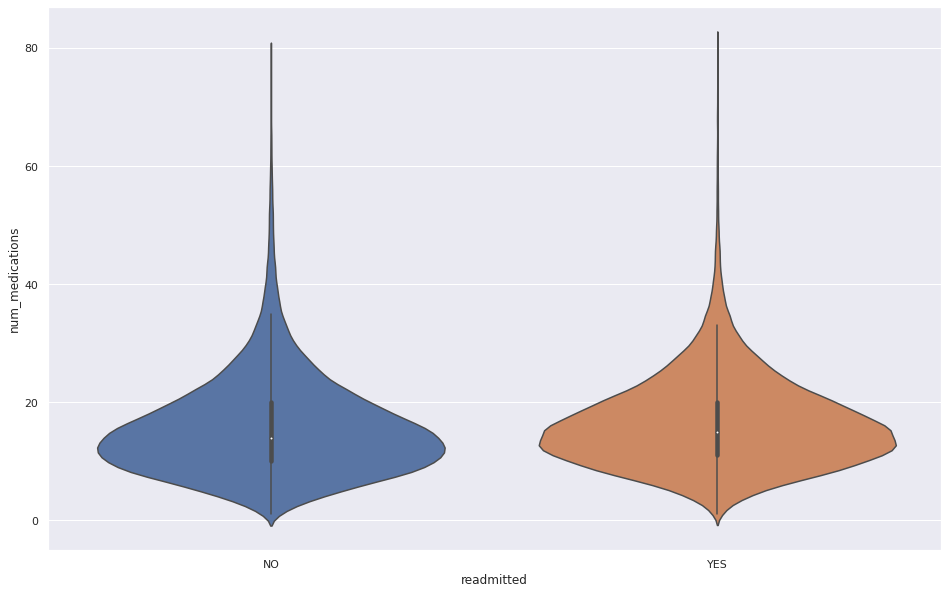

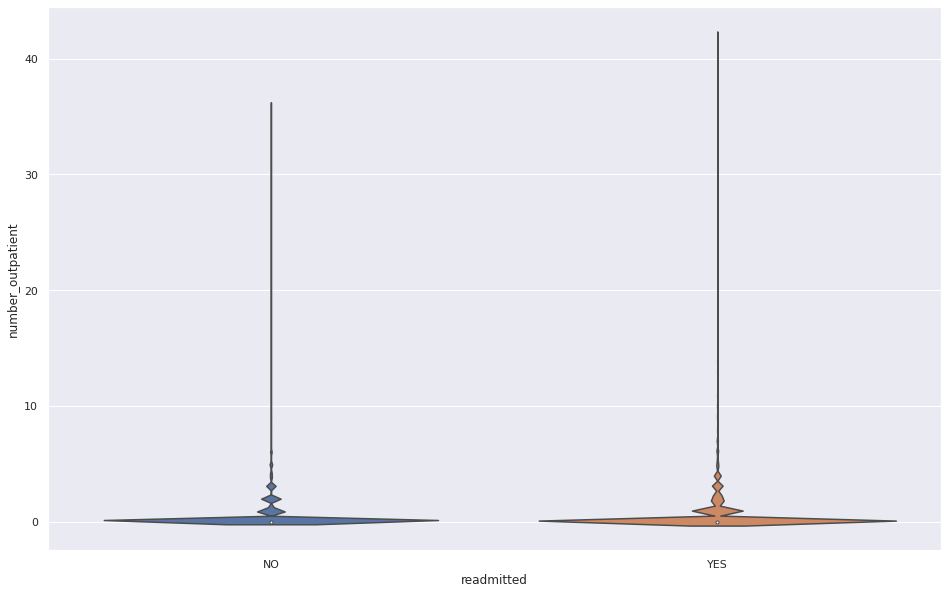

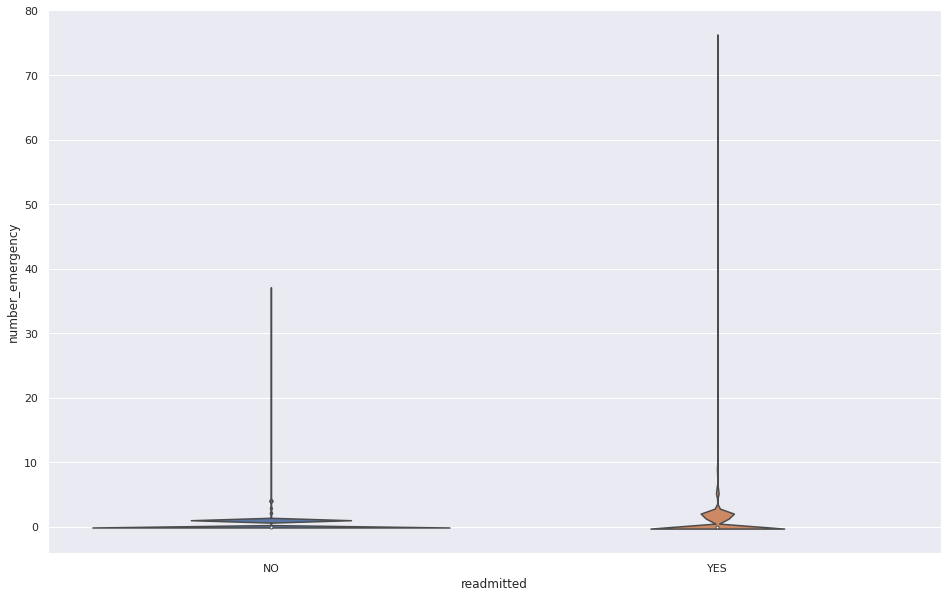

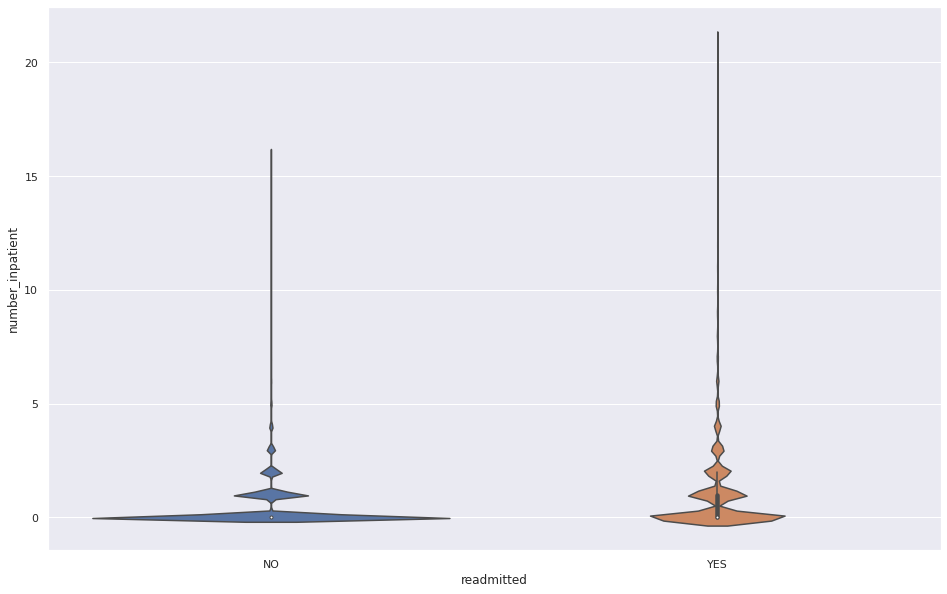

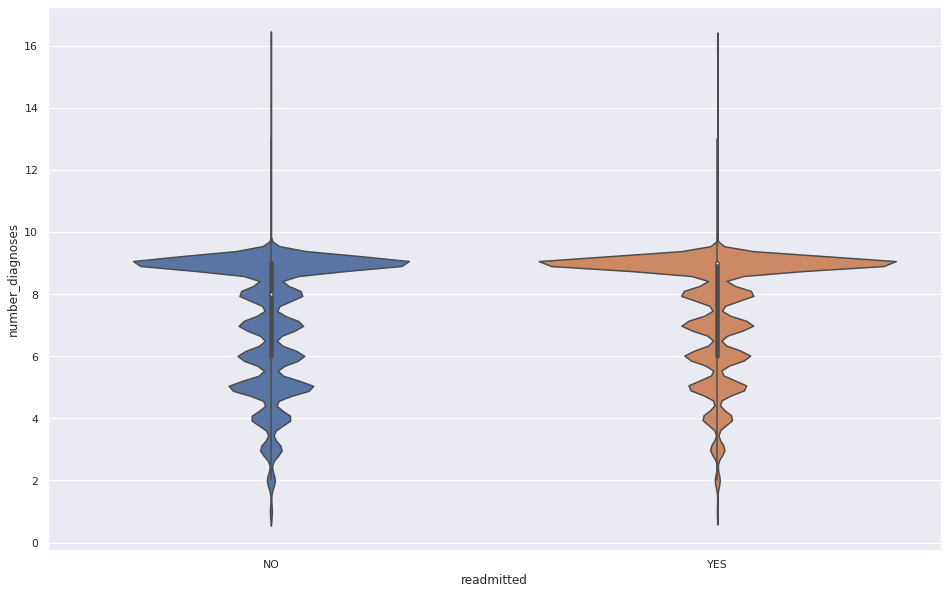

In [14]:
def violin_plots(x,y, data): 
    for i, col in enumerate(y):
        plt.figure(i)
        sns.set(rc = {'figure.figsize' : (16, 10)})
        ax = sns.violinplot(x=x, y = col, data = diabetes)

y = diabetes[num_cleaned]
x = diabetes.columns[-1]

violin_plots(x,y,diabetes)

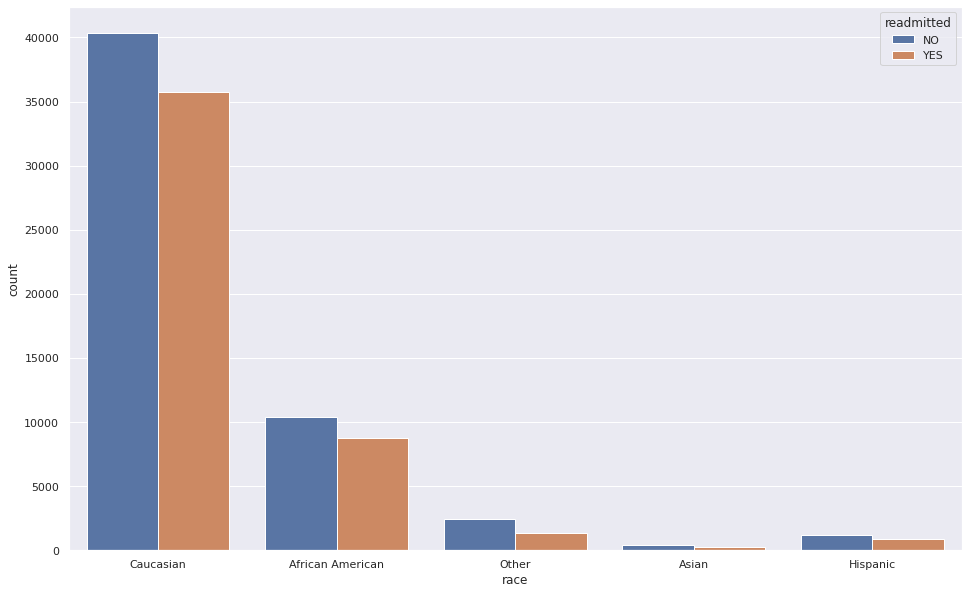

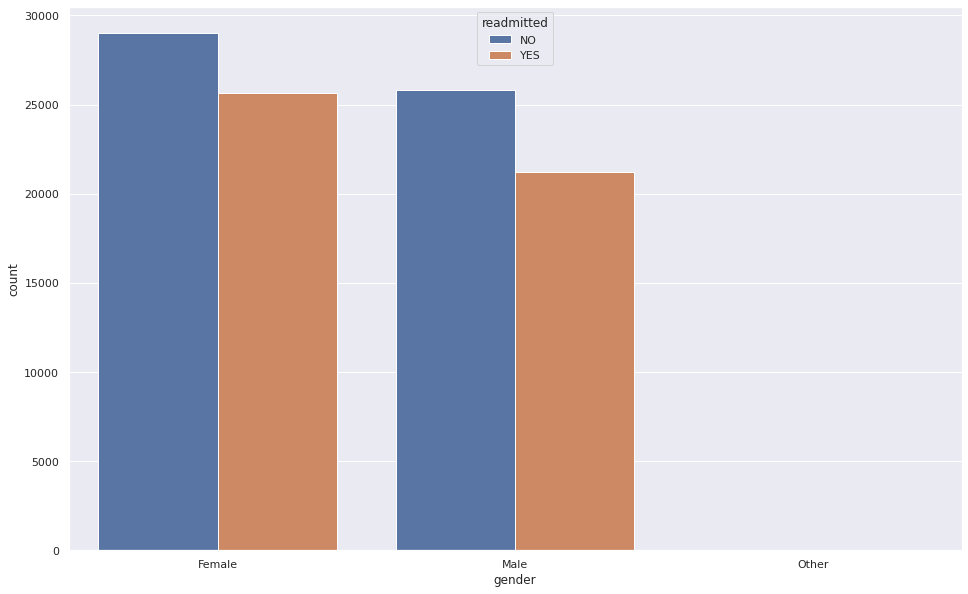

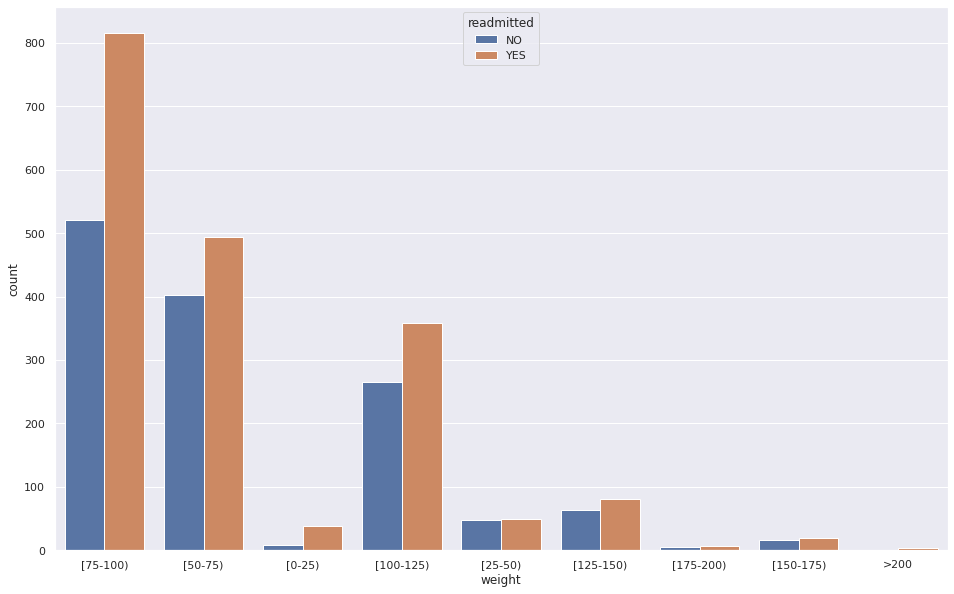

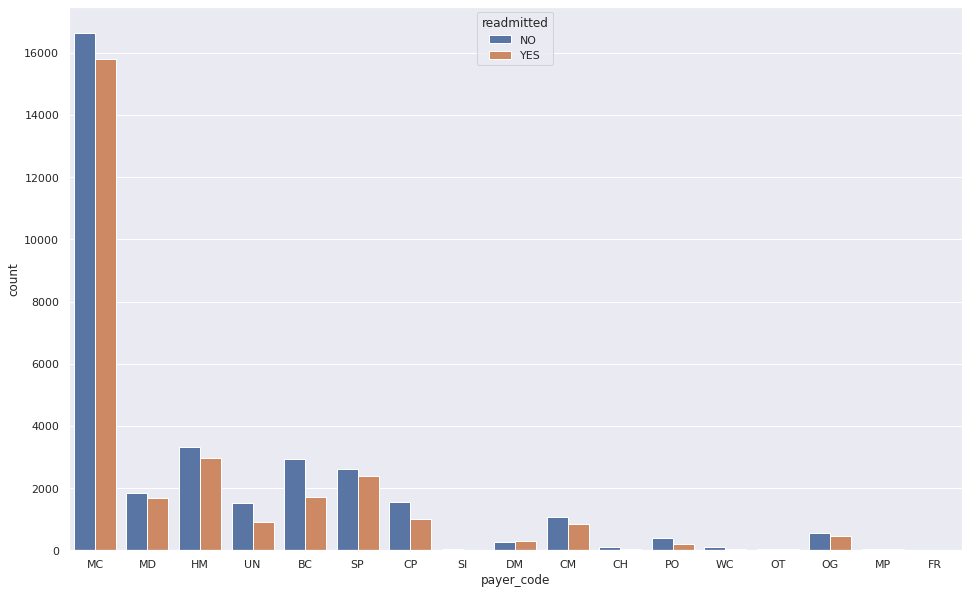

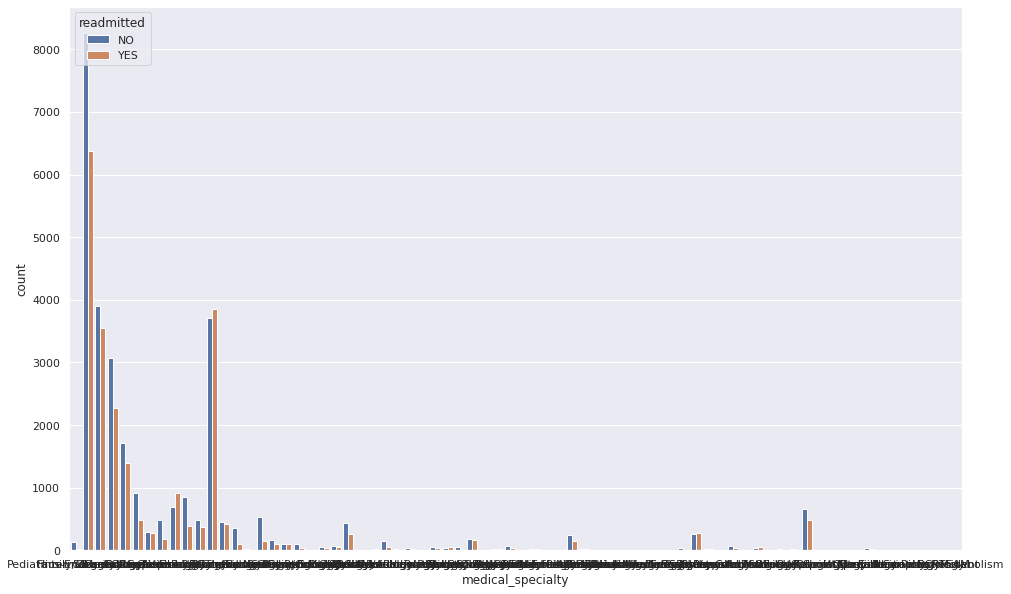

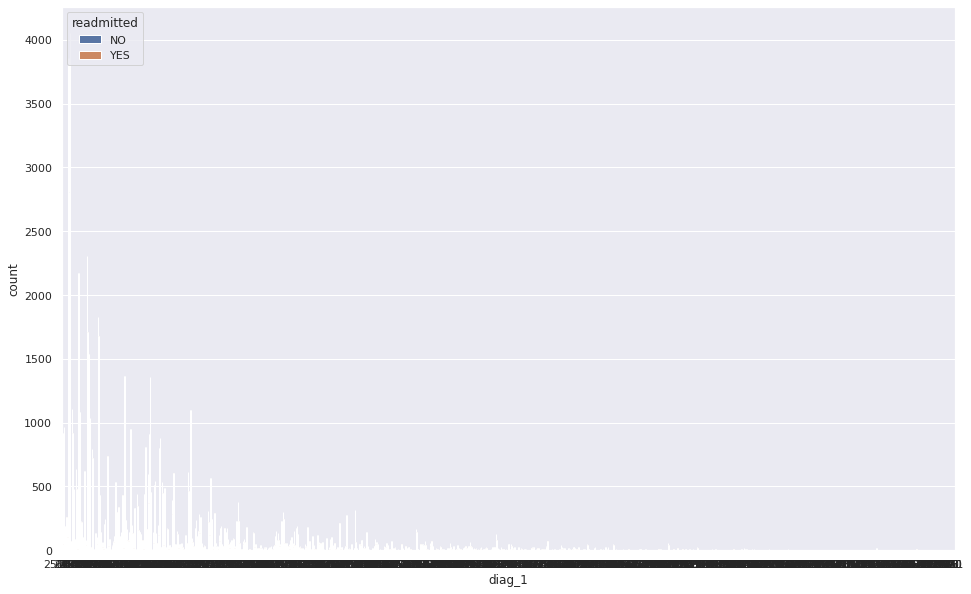

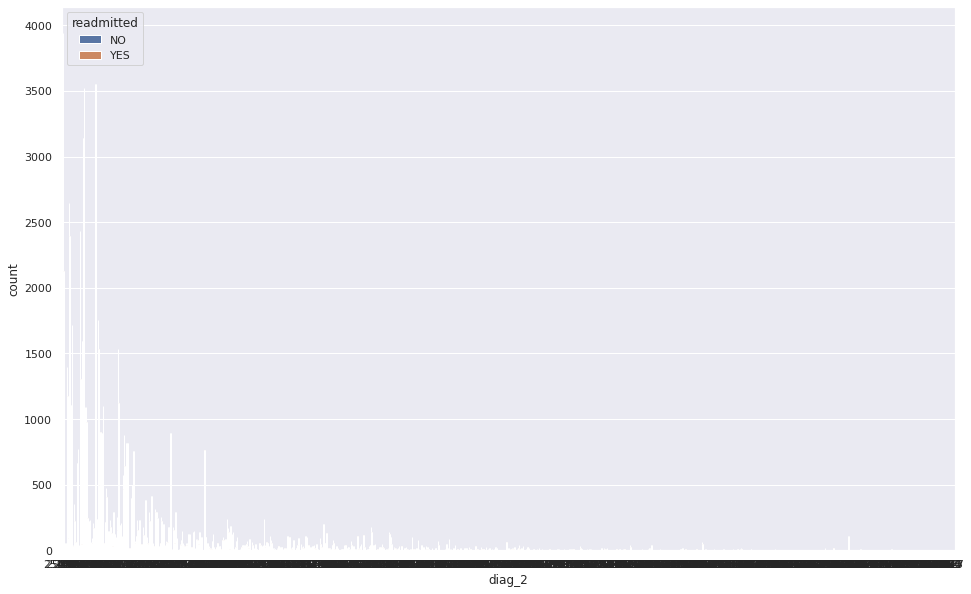

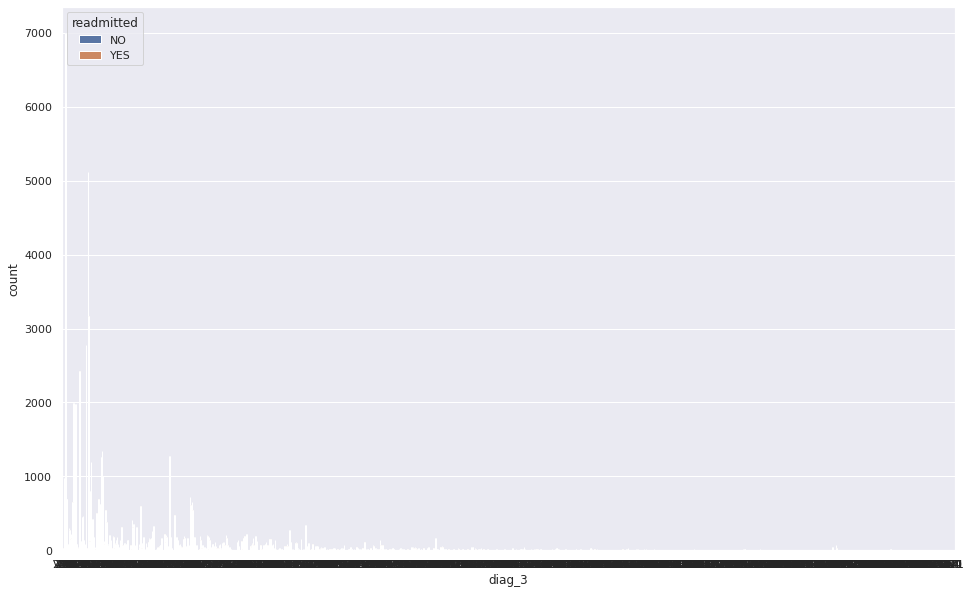

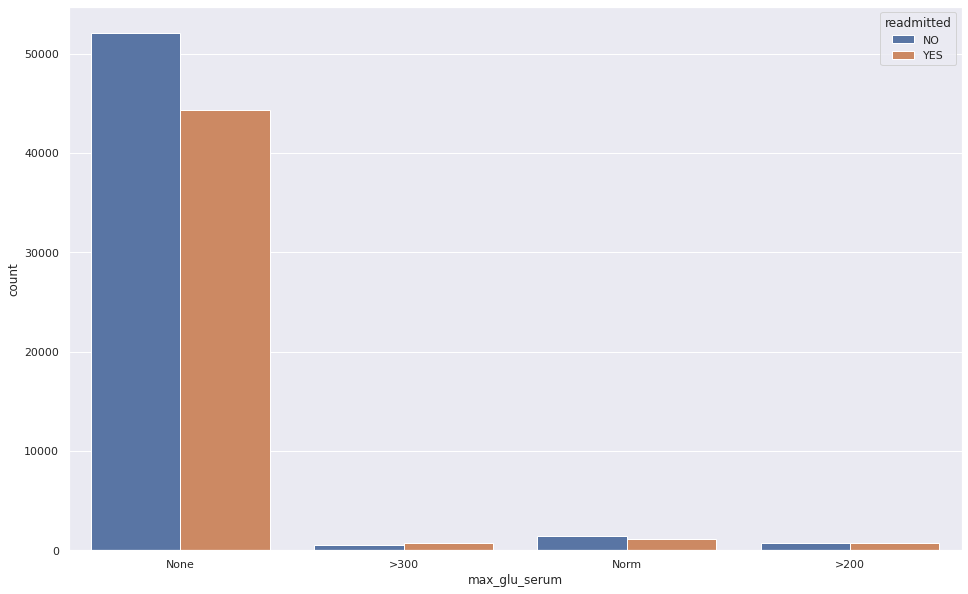

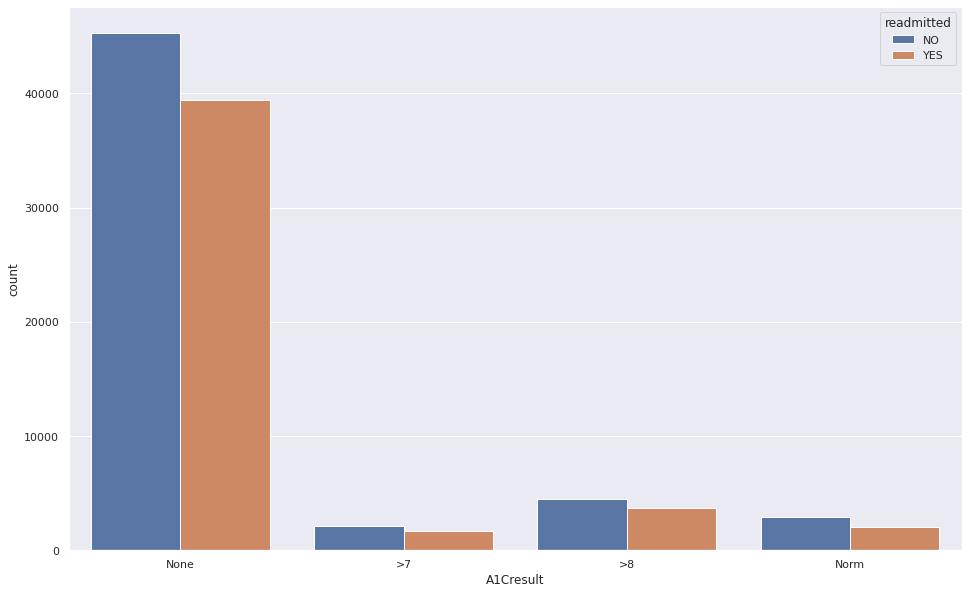

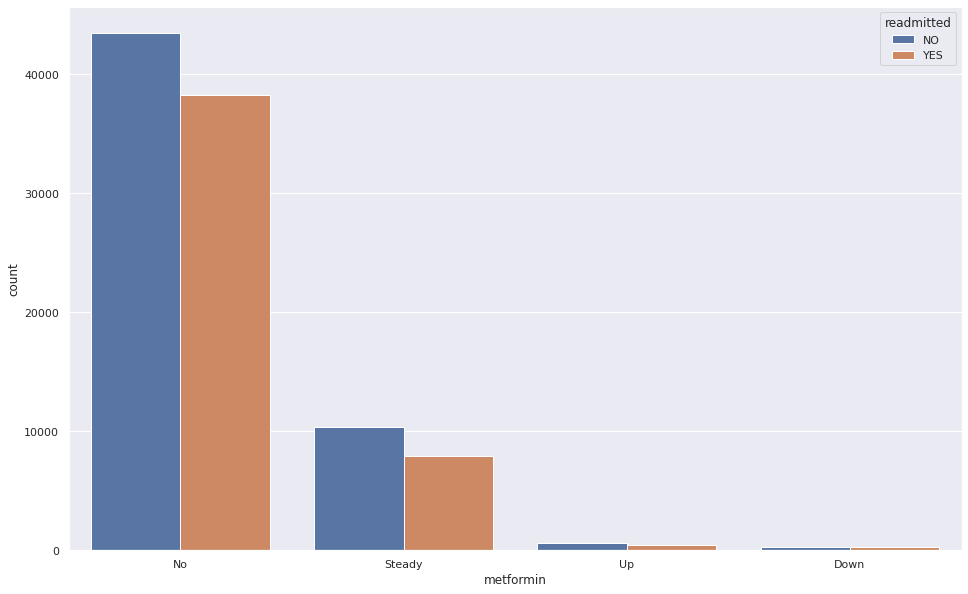

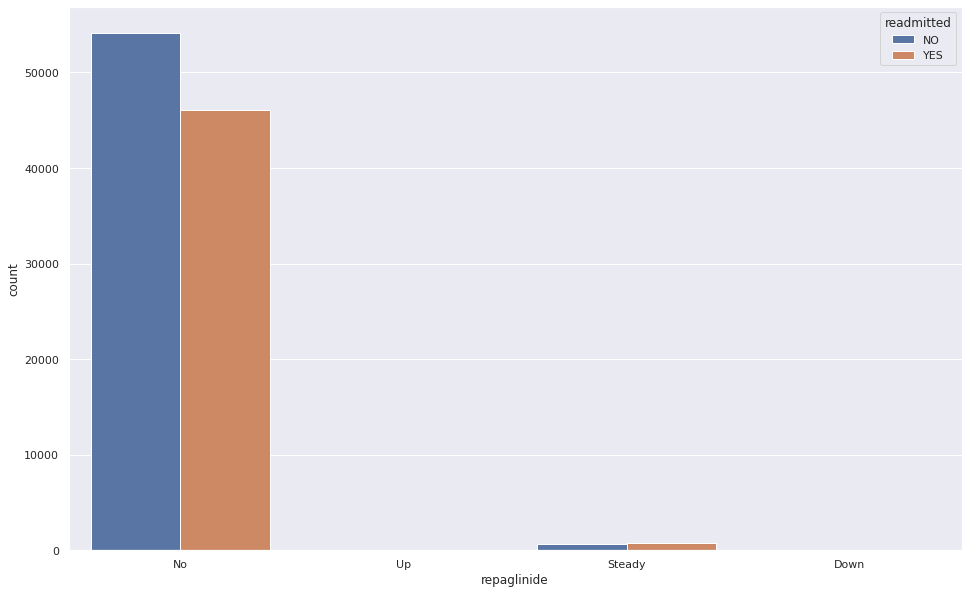

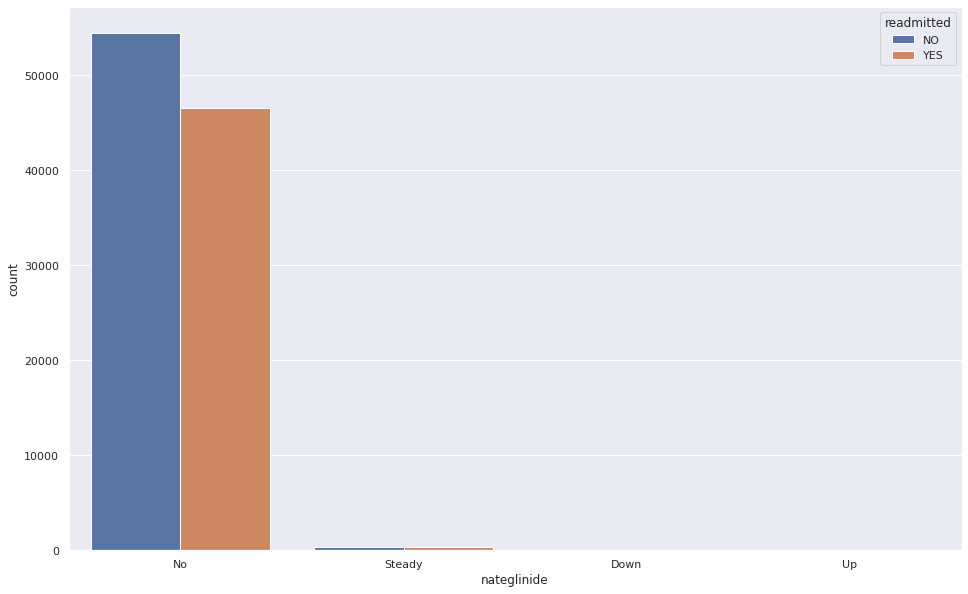

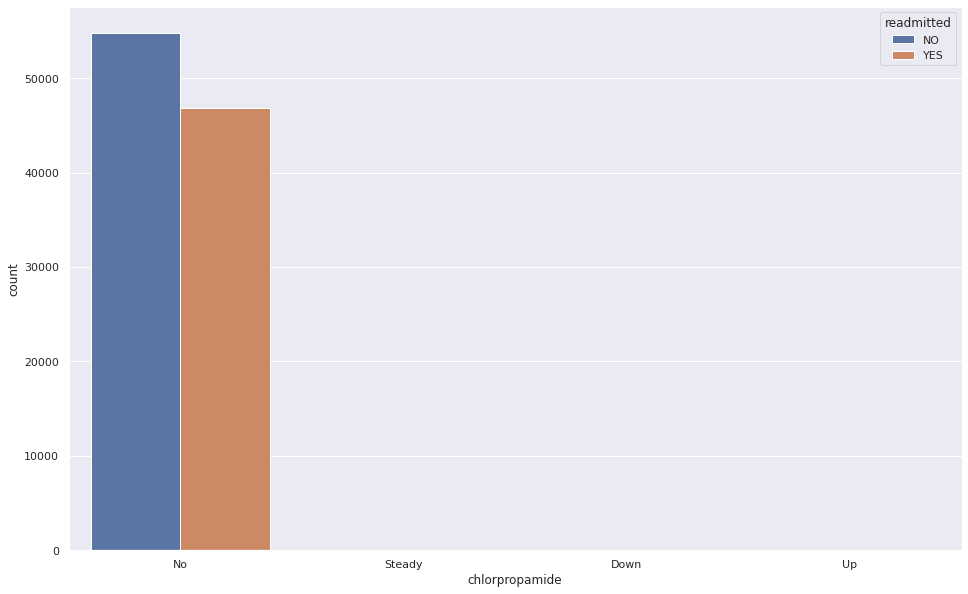

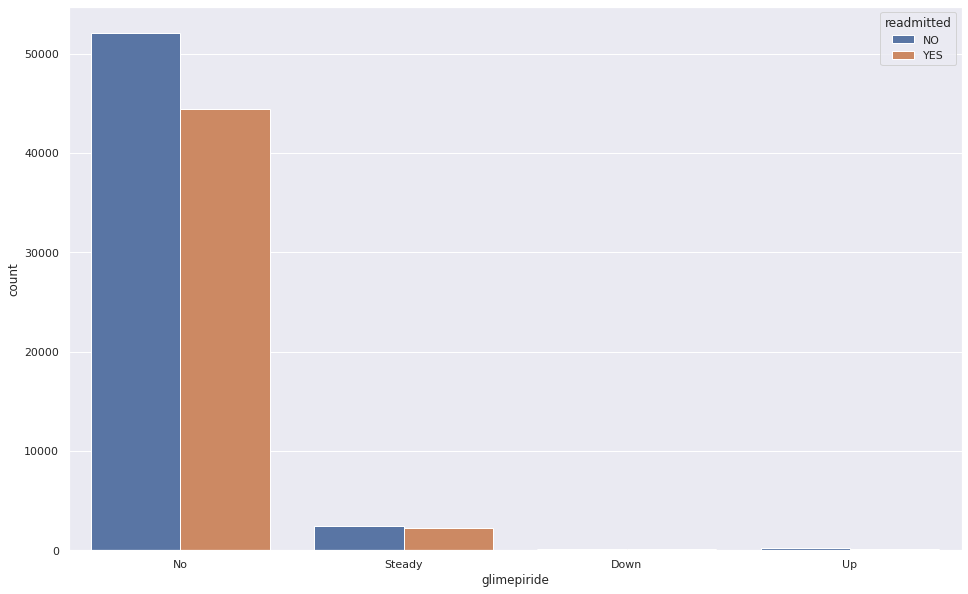

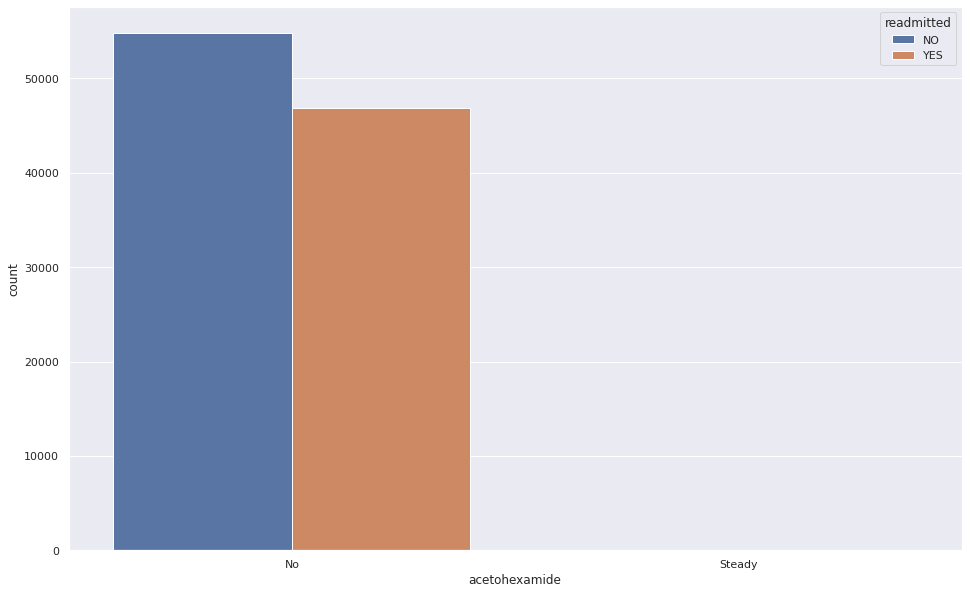

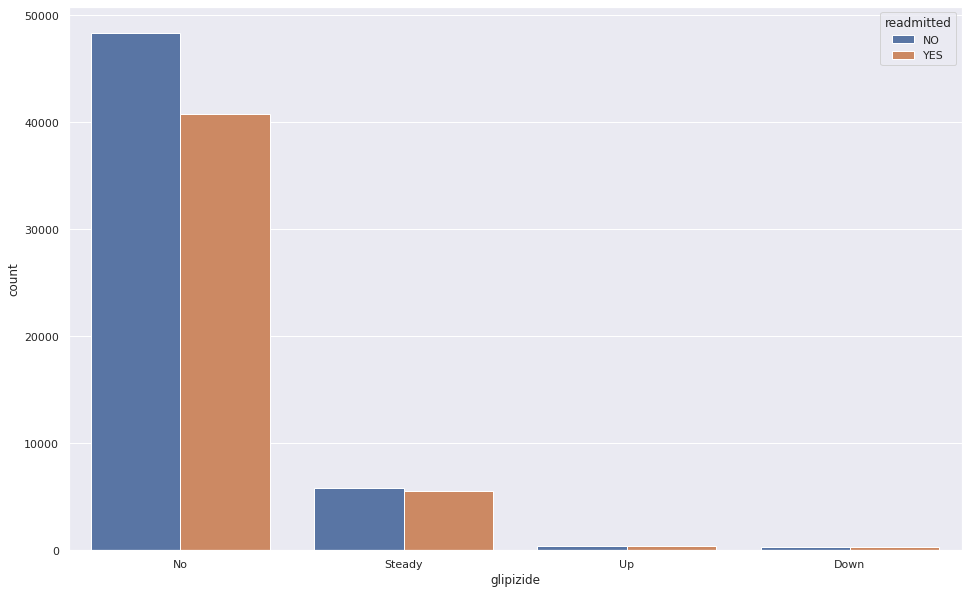

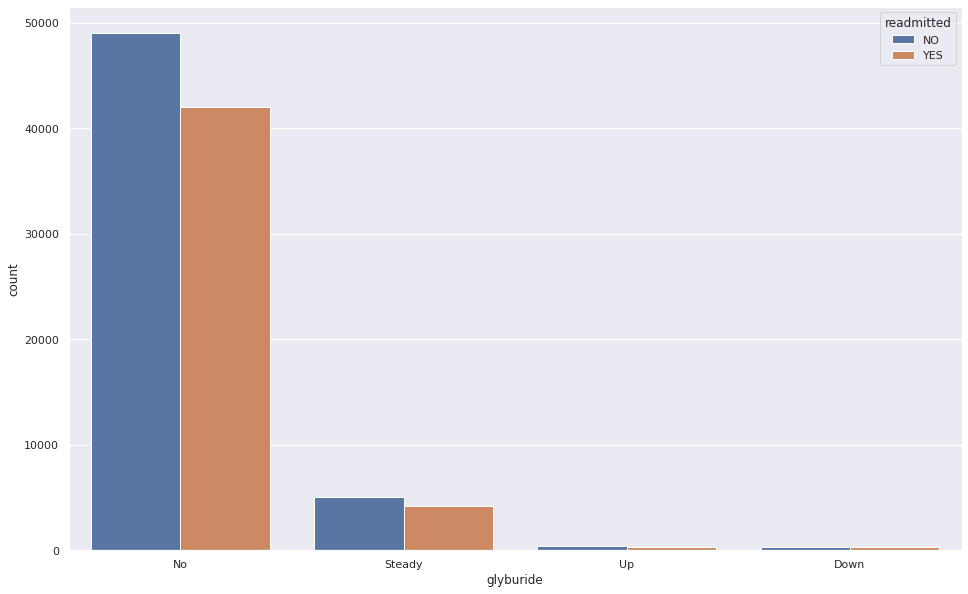

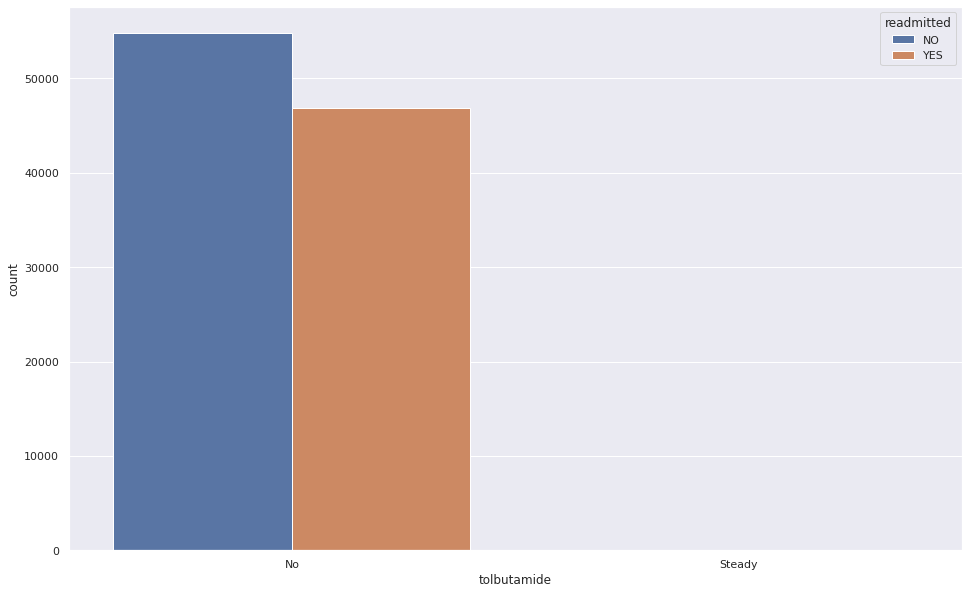

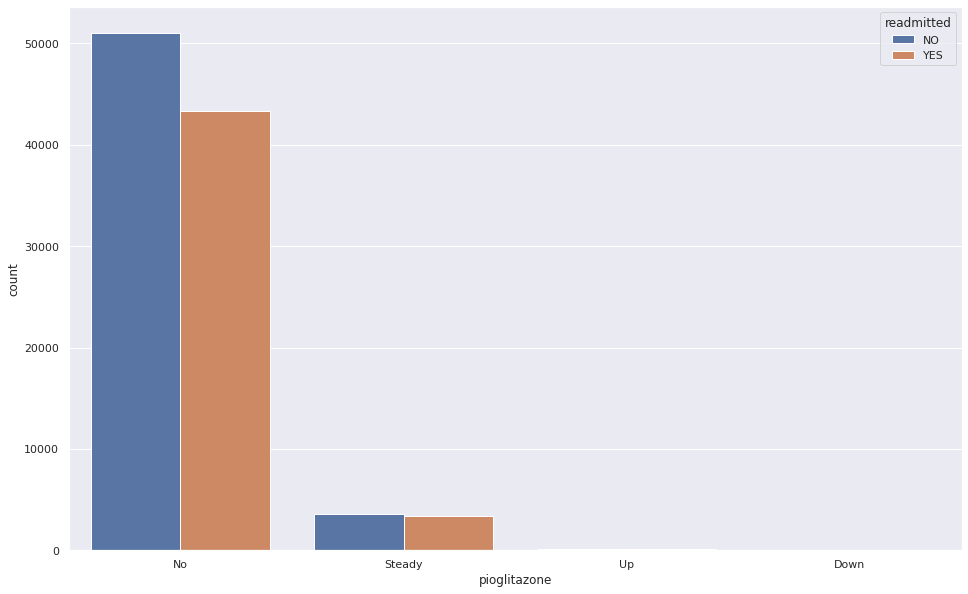

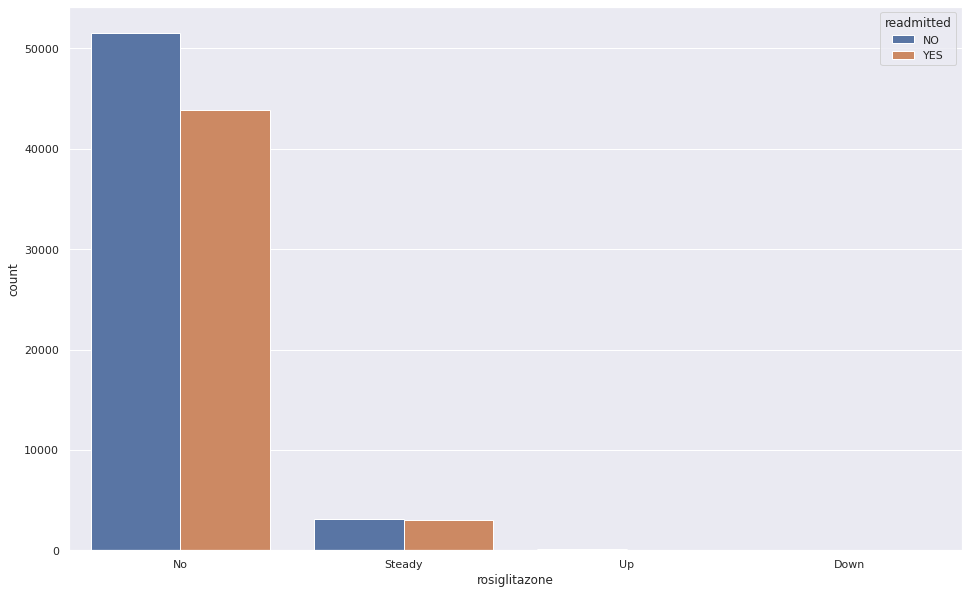

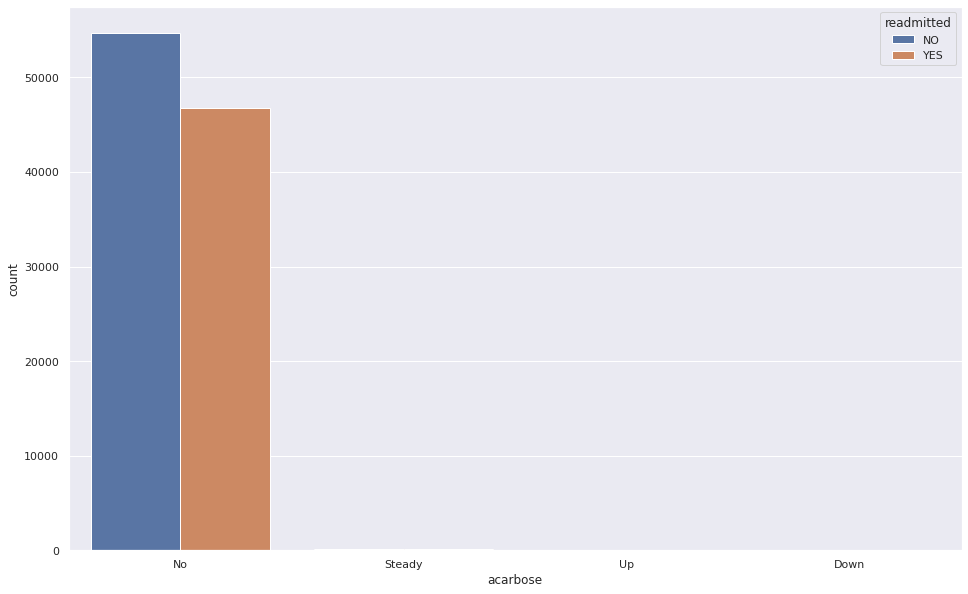

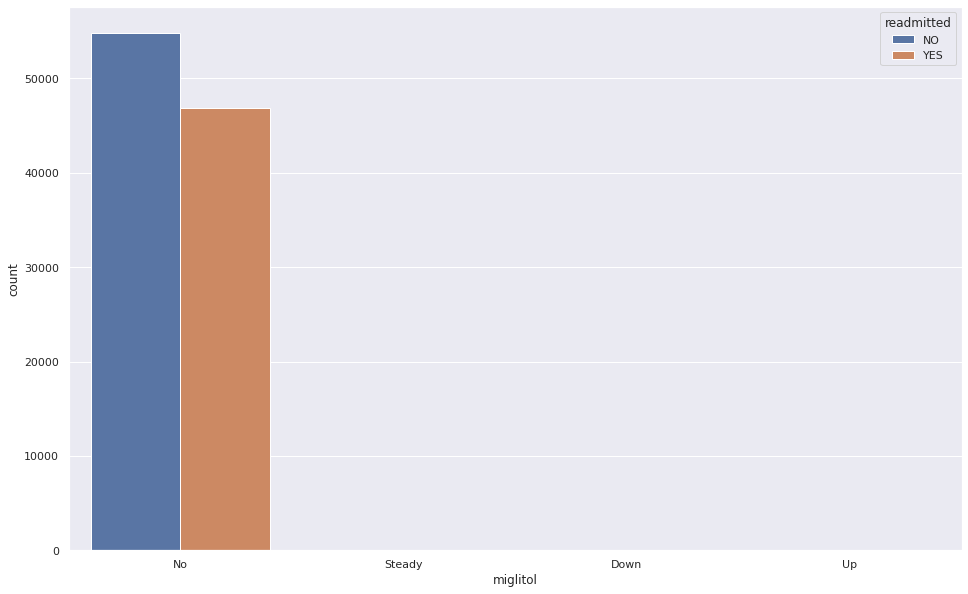

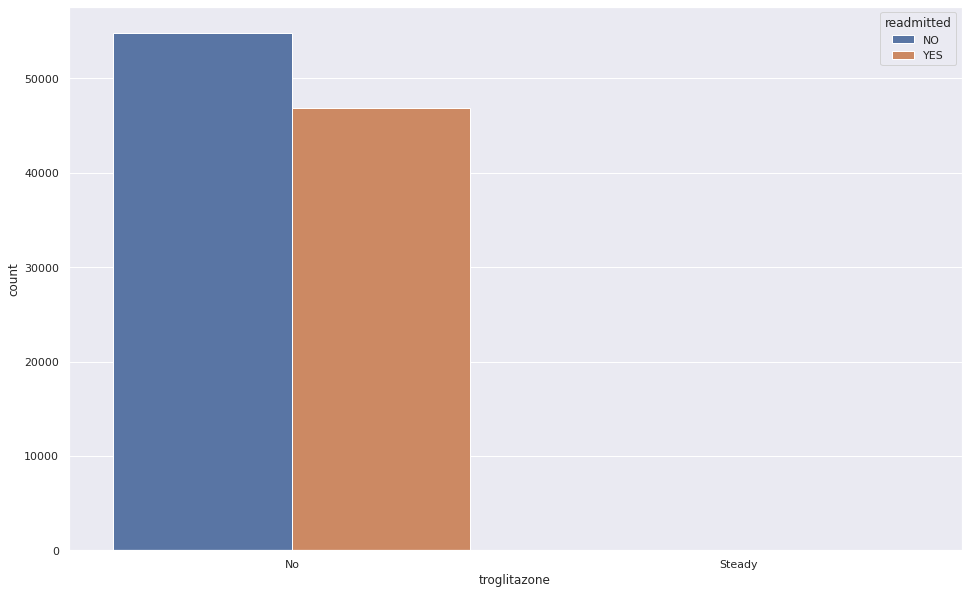

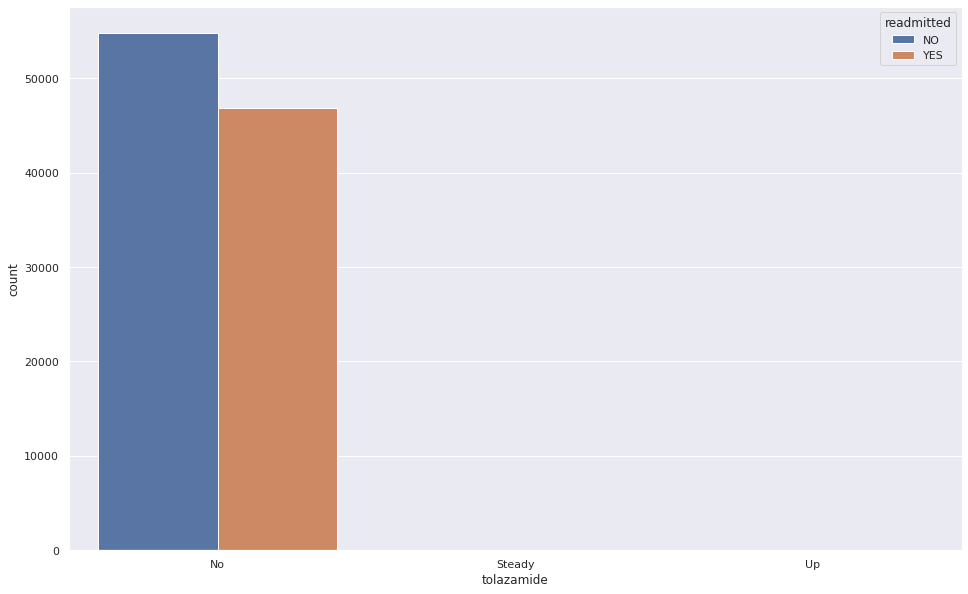

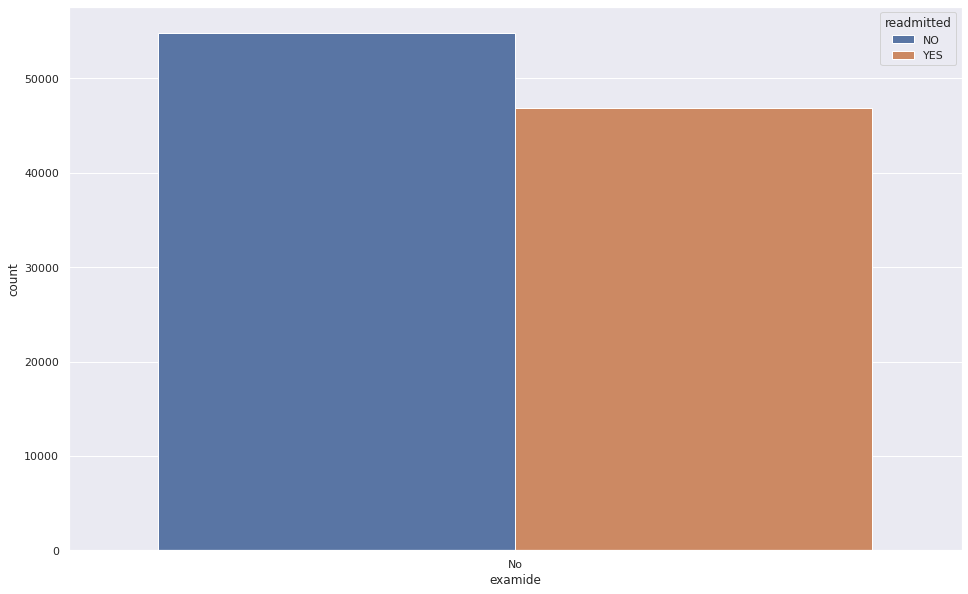

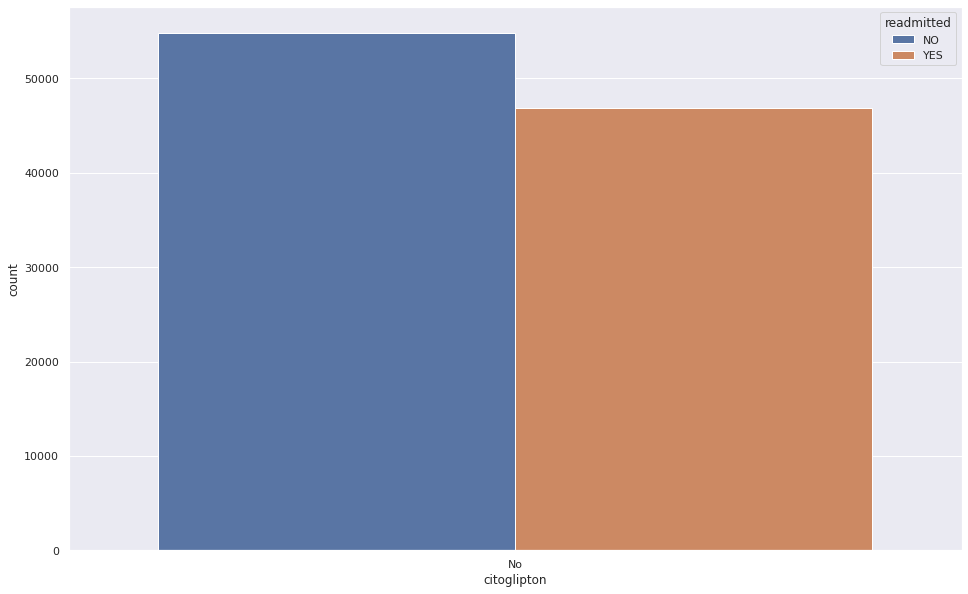

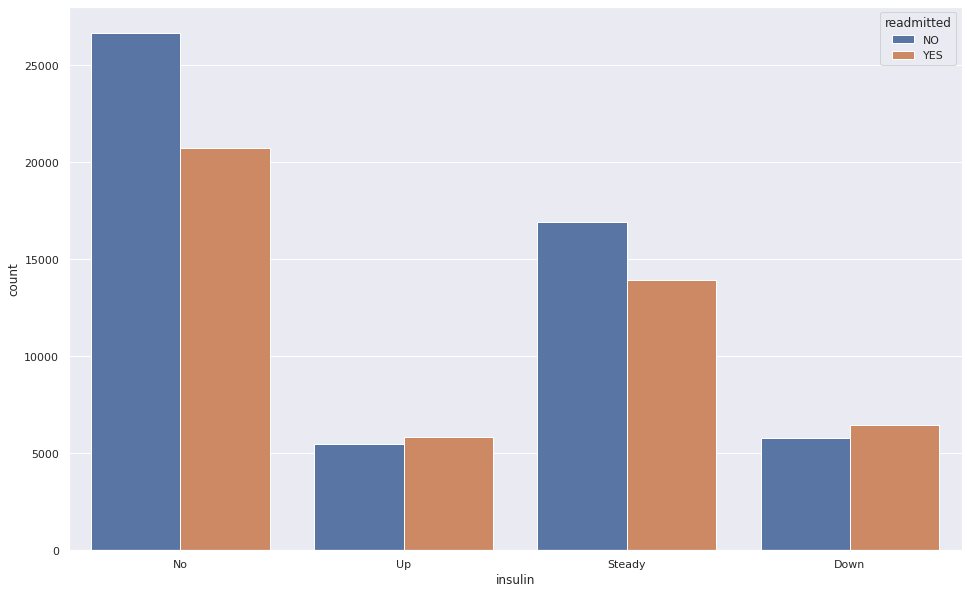

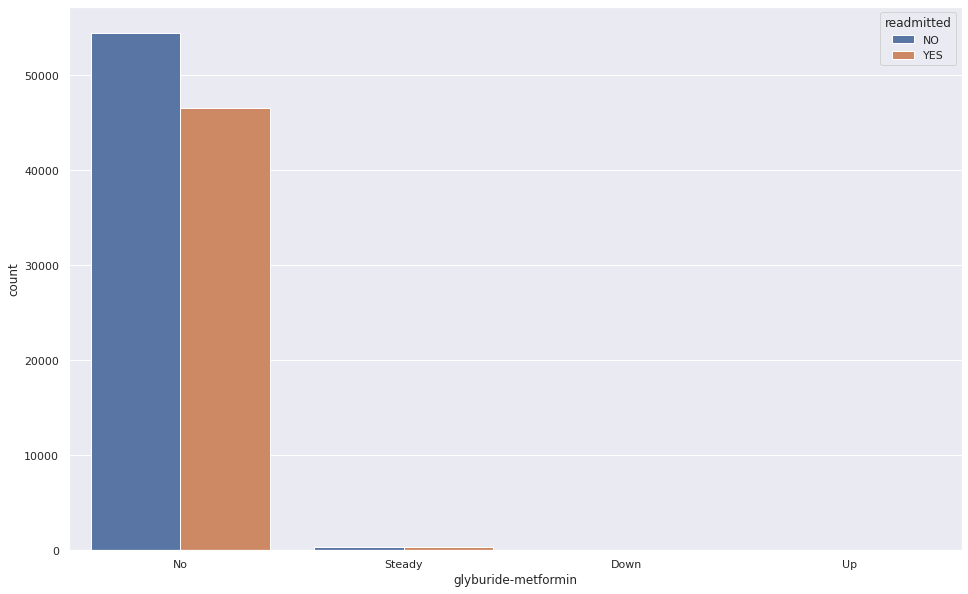

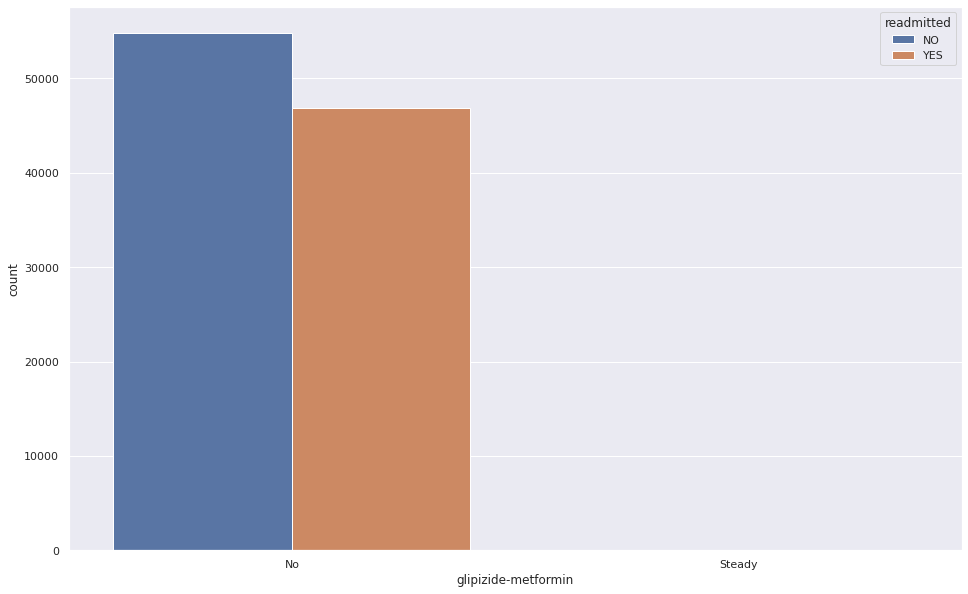

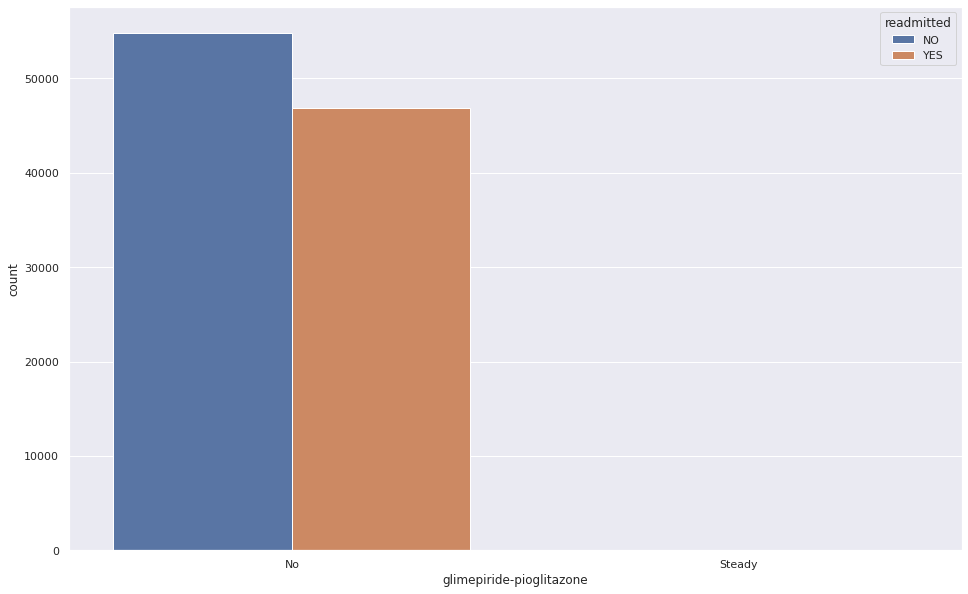

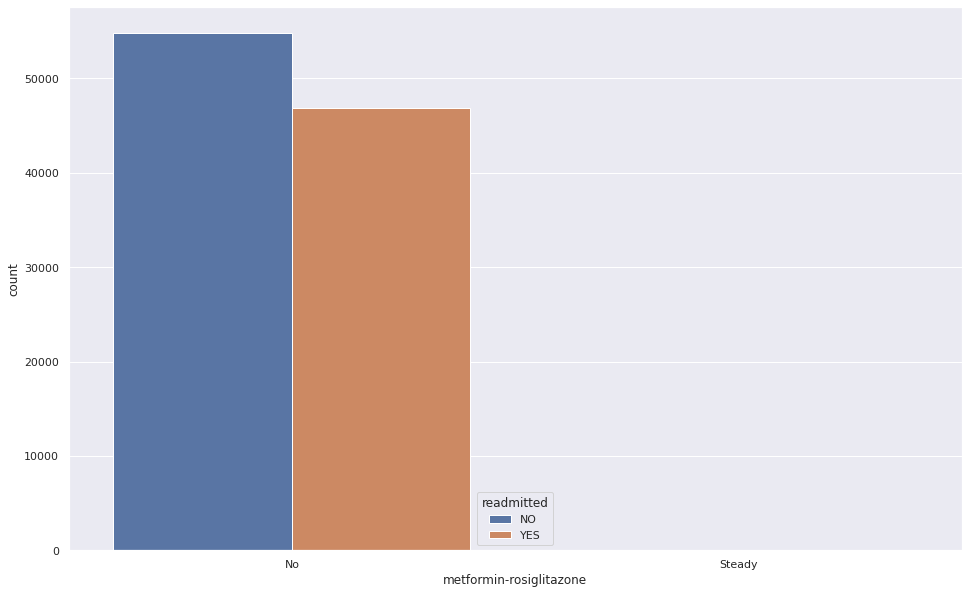

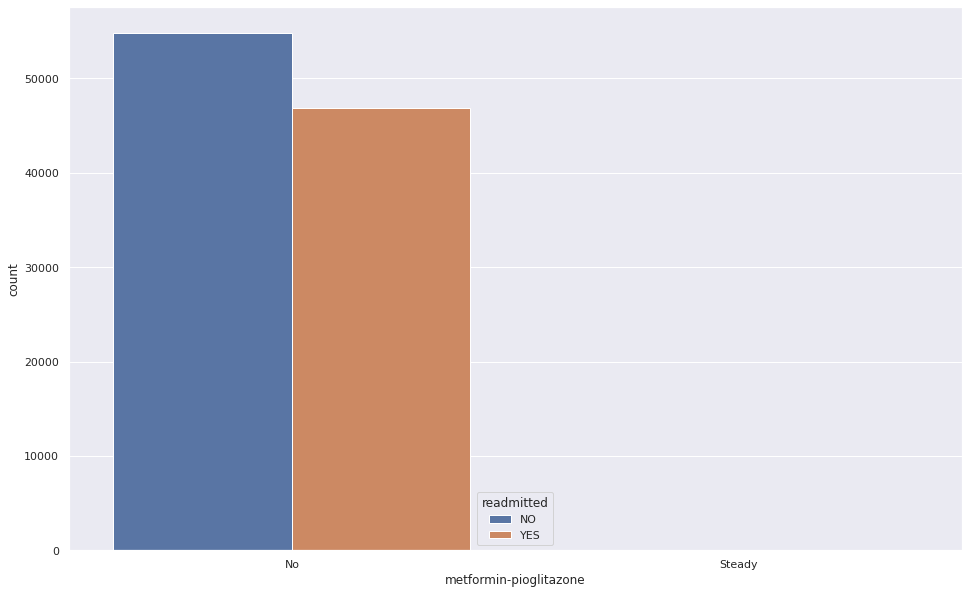

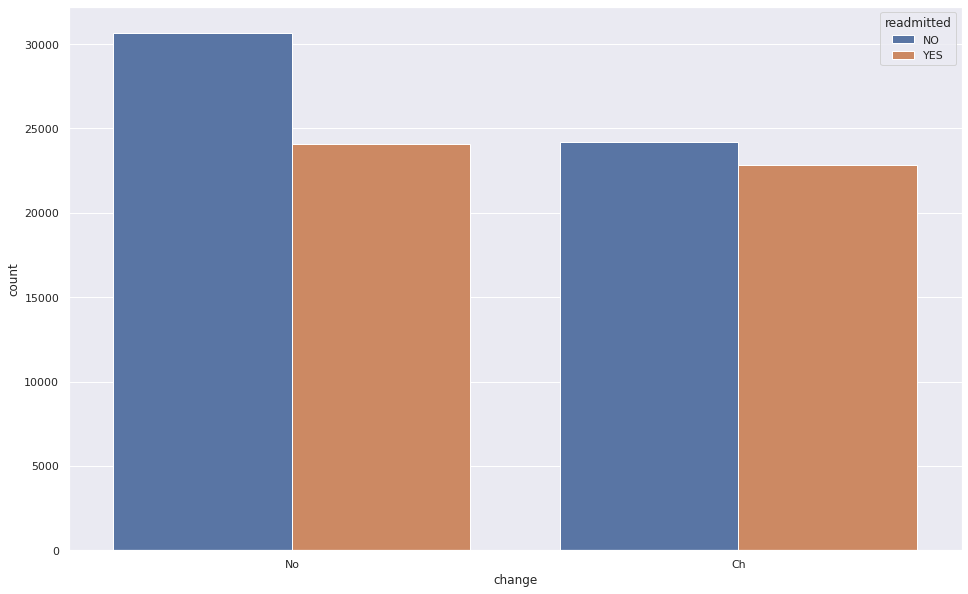

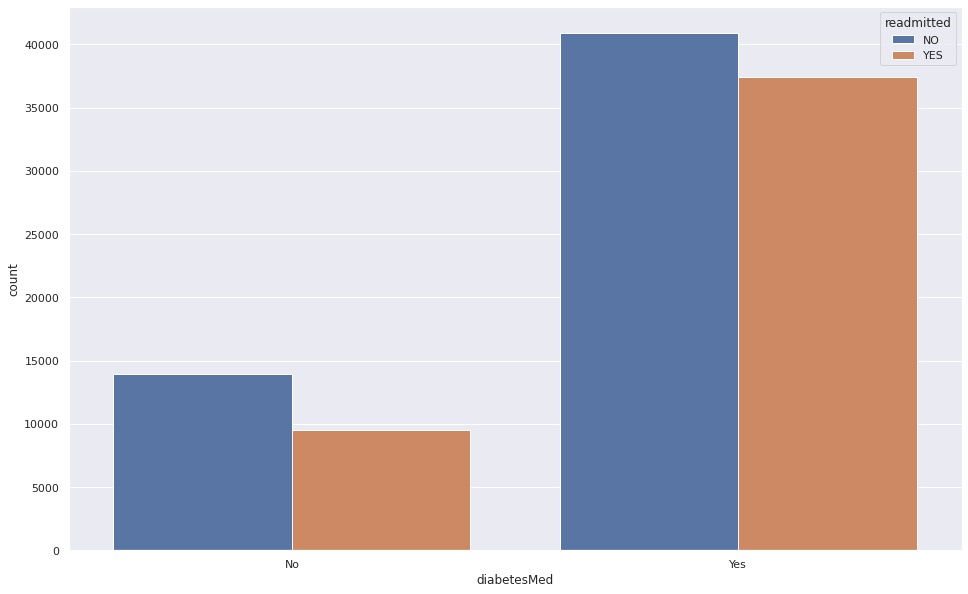

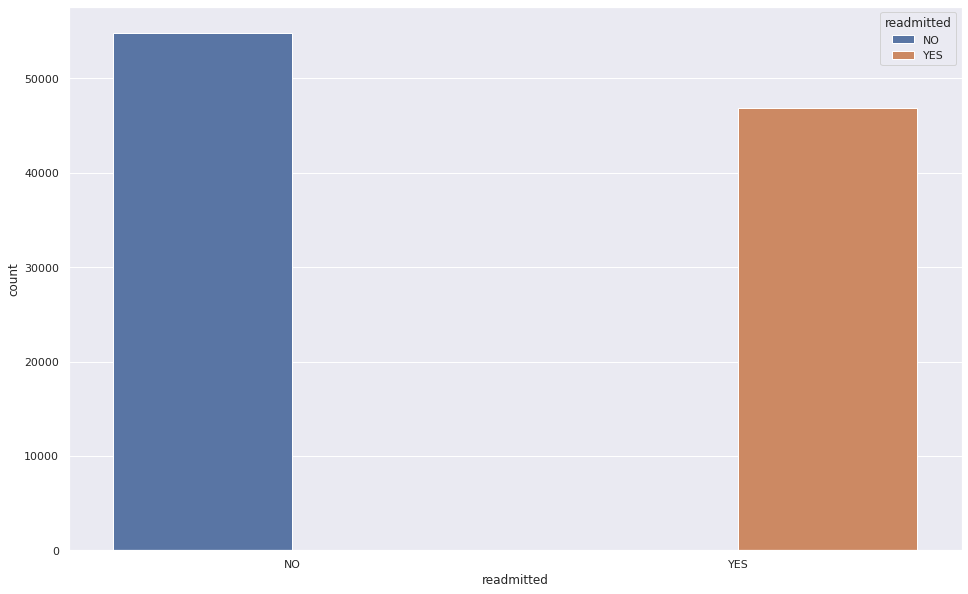

In [15]:
def plot_data(data):
    for i, col in enumerate(diabetes[cat]):
        plt.figure(i)
        ax = sns.countplot(x=data[col], hue= data['readmitted'], data=diabetes)

plot_data(diabetes)

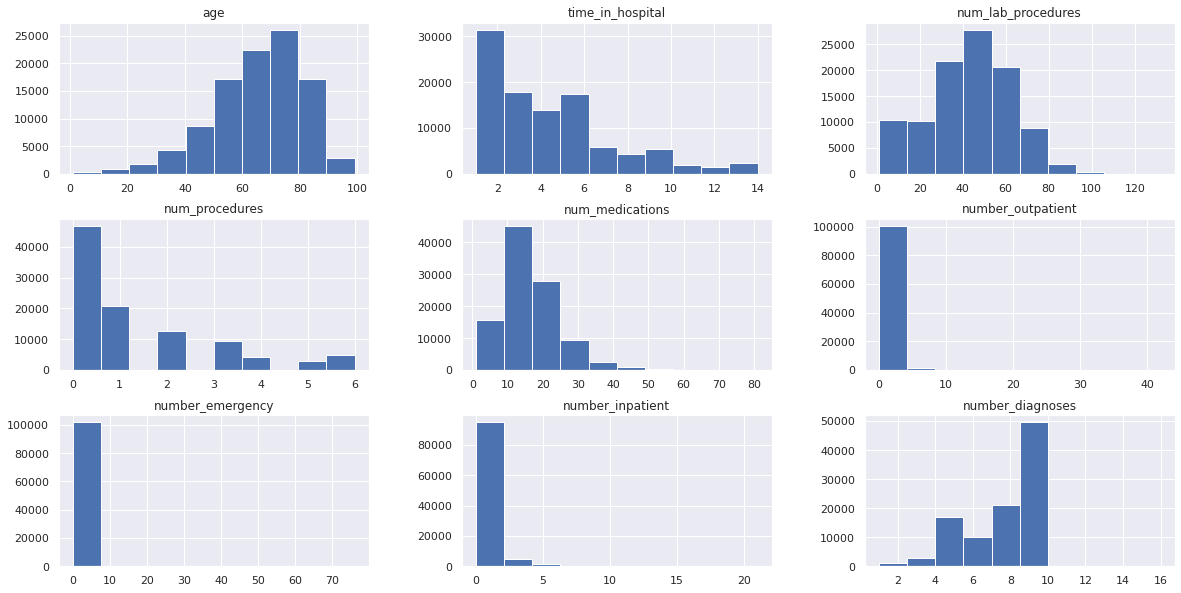

In [16]:
diabetes[num_cleaned].hist(figsize=(20,10));

#### Statistics  
- IF mean < median THEN **left skew** (negative)
- IF mean > median THEN **right skew** (positive) 
- IF mean = median THEN **Gaussian** (normal) 

In [17]:
diabetes[num_cleaned].describe()

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,65.483324,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,16.195283,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,55.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,67.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,77.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,99.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


In [18]:
diabetes[num_cleaned].corr()

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
age,1.000000,0.105099,0.019834,-0.030061,0.041045,0.023488,-0.085382,-0.041938,0.238576
time_in_hospital,0.105099,1.000000,0.318450,0.191472,0.466135,-0.008916,-0.009681,0.073623,0.220186
num_lab_procedures,0.019834,0.318450,1.000000,0.058066,0.268161,-0.007602,-0.002279,0.039231,0.152773
num_procedures,-0.030061,0.191472,0.058066,1.000000,0.385767,-0.024819,-0.038179,-0.066236,0.073734
num_medications,0.041045,0.466135,0.268161,0.385767,1.000000,0.045197,0.013180,0.064194,0.261526
number_outpatient,0.023488,-0.008916,-0.007602,-0.024819,0.045197,1.000000,0.091459,0.107338,0.094152
number_emergency,-0.085382,-0.009681,-0.002279,-0.038179,0.013180,0.091459,1.000000,0.266559,0.055539
number_inpatient,-0.041938,0.073623,0.039231,-0.066236,0.064194,0.107338,0.266559,1.000000,0.104710
number_diagnoses,0.238576,0.220186,0.152773,0.073734,0.261526,0.094152,0.055539,0.104710,1.000000


In [19]:
diabetes[num_cleaned].kurtosis()

age                      0.256282
time_in_hospital         0.850251
num_lab_procedures      -0.245074
num_procedures           0.857110
num_medications          3.468155
number_outpatient      147.907736
number_emergency      1191.686726
number_inpatient        20.719397
number_diagnoses        -0.079056
dtype: float64

In [20]:
diabetes[num_cleaned].skew()

age                   -0.599330
time_in_hospital       1.133999
num_lab_procedures    -0.236544
num_procedures         1.316415
num_medications        1.326672
number_outpatient      8.832959
number_emergency      22.855582
number_inpatient       3.614139
number_diagnoses      -0.876746
dtype: float64

In [21]:
diabetes.groupby('readmitted')[num_cleaned].mean()

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
readmitted,,,,,,,,,
NO,65.040883,4.254429,42.381598,1.410305,15.670367,0.273112,0.109216,0.381963,7.221366
YES,66.000874,4.561575,43.930898,1.257175,16.432988,0.481941,0.301501,0.932220,7.658010


In [ ]:
diabetes[['age', 'time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses', 'readmitted']].corr()

number_diagnoses, number_inpatient, number_emergency  

In [23]:
diabetes.drop(columns = {'encounter_id', 'patient_nbr', 'weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3'}, inplace= True)
diabetes.isnull().sum()

race                        0
gender                      0
age                         0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazone                0
rosiglitazone               0
acarbose                    0
miglitol                    0
troglitazone                0
tolazamide                  0
examide                     0
citoglipton                 0
insulin   

In [24]:
cat = list(diabetes.select_dtypes(['object']).columns)
def cat_mut_inf(series):
    return mutual_info_score(series, diabetes['readmitted']) 

binary_cat = diabetes[cat].apply(cat_mut_inf)
binary_cat = binary_cat.sort_values(ascending=False).to_frame(name='mutual_info_score')
binary_cat

,mutual_info_score
readmitted,0.690083
insulin,0.002339
diabetesMed,0.001903
race,0.001297
change,0.001058
metformin,0.000414
A1Cresult,0.000264
repaglinide,0.000254
max_glu_serum,0.000241
glipizide,0.000223


insulin, diabetesMed, race 

### Preprocessing 

In [25]:
t = diabetes['readmitted'].value_counts()
print(f'Original values:\n{t}')
le = LabelEncoder() 
diabetes['readmitted'] = le.fit_transform(diabetes['readmitted'])
t = diabetes['readmitted'].value_counts()
print(f'Modified values:\n{t}')

Original values:
NO     54864
YES    46902
Name: readmitted, dtype: int64
Modified values:
0    54864
1    46902
Name: readmitted, dtype: int64


['max_glu_serum', 'A1Cresult', 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'citoglipton',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'change']

In [26]:
print('Transformed column of interest as seen:')
display(diabetes.head(5))
#encoded_data = pd.get_dummies(diabetes, drop_first = False)
to_encode = diabetes.copy(deep = True)
to_encode.columns.astype(str)

Transformed column of interest as seen:


,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,3,6,25,1,1,41,0,1,...,No,No,No,No,No,No,No,No,No,0
1,Caucasian,Female,18,1,1,7,3,59,0,18,...,No,Up,No,No,No,No,No,Ch,Yes,1
2,African American,Female,27,1,1,7,2,11,5,13,...,No,No,No,No,No,No,No,No,Yes,0
3,Caucasian,Male,30,1,1,7,2,44,1,16,...,No,Up,No,No,No,No,No,Ch,Yes,0
4,Caucasian,Male,48,1,1,7,1,51,0,8,...,No,Steady,No,No,No,No,No,Ch,Yes,0


Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [27]:
encoded_data = pd.get_dummies(to_encode)
print('One hot encoding of all columns:')
display(encoded_data.head(5))
list(encoded_data.columns)

One hot encoding of all columns:


,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,...,glimepiride-pioglitazone_No,glimepiride-pioglitazone_Steady,metformin-rosiglitazone_No,metformin-rosiglitazone_Steady,metformin-pioglitazone_No,metformin-pioglitazone_Steady,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
0,3,6,25,1,1,41,0,1,0,0,...,1,0,1,0,1,0,0,1,1,0
1,18,1,1,7,3,59,0,18,0,0,...,1,0,1,0,1,0,1,0,0,1
2,27,1,1,7,2,11,5,13,2,0,...,1,0,1,0,1,0,0,1,0,1
3,30,1,1,7,2,44,1,16,0,0,...,1,0,1,0,1,0,1,0,0,1
4,48,1,1,7,1,51,0,8,0,0,...,1,0,1,0,1,0,1,0,0,1


['age',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses',
 'readmitted',
 'race_African American',
 'race_Asian',
 'race_Caucasian',
 'race_Hispanic',
 'race_Other',
 'gender_Female',
 'gender_Male',
 'gender_Other',
 'max_glu_serum_>200',
 'max_glu_serum_>300',
 'max_glu_serum_None',
 'max_glu_serum_Norm',
 'A1Cresult_>7',
 'A1Cresult_>8',
 'A1Cresult_None',
 'A1Cresult_Norm',
 'metformin_Down',
 'metformin_No',
 'metformin_Steady',
 'metformin_Up',
 'repaglinide_Down',
 'repaglinide_No',
 'repaglinide_Steady',
 'repaglinide_Up',
 'nateglinide_Down',
 'nateglinide_No',
 'nateglinide_Steady',
 'nateglinide_Up',
 'chlorpropamide_Down',
 'chlorpropamide_No',
 'chlorpropamide_Steady',
 'chlorpropamide_Up',
 'glimepiride_Down',
 'glimepiride_No',
 'glimepiride_Steady',
 'glimepiride_Up',
 'acetohexam

## Modeling 

### Sampling and splitting dataset 


In [28]:
train_df, valid_df, test_df = np.split(encoded_data.sample(frac=1, random_state=42), 
                                       [int(.7*len(encoded_data)), int(0.85*len(encoded_data))])
train_df = train_df.reset_index(drop = True)
valid_df = valid_df.reset_index(drop = True)
test_df = test_df.reset_index(drop = True)

In [29]:
display(encoded_data.readmitted.value_counts())
display(train_df.readmitted.value_counts())
display(valid_df.readmitted.value_counts())
display(test_df.readmitted.value_counts())


0    54864
1    46902
Name: readmitted, dtype: int64

0    38357
1    32879
Name: readmitted, dtype: int64

0    8263
1    7002
Name: readmitted, dtype: int64

0    8244
1    7021
Name: readmitted, dtype: int64

In [30]:
def calc_prevalence(y_actual):
    
    '''
    This function is to understand the ratio/distribution of the classes that we are going to predict for.
    
    Params:
    1. y_actual: The target feature
    
    Return:
    1. (sum(y_actual)/len(y_actual)): The ratio of the postive class in the comlpete data.
    '''
    
    return (sum(y_actual)/len(y_actual))

In [31]:
# split the training data into positive and negative
rows_pos = train_df.readmitted == 1
df_train_pos = train_df.loc[rows_pos]
df_train_neg = train_df.loc[~rows_pos]

# merge the balanced data
diabetes_df_balanced = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 111)],axis = 0)

# shuffle the order of training samples 
diabetes_df_balanced = diabetes_df_balanced.sample(n = len(diabetes_df_balanced), random_state = 42).reset_index(drop = True)

print('Train balanced prevalence(n = %d): %.3f'%(len(diabetes_df_balanced), \
                                                calc_prevalence(diabetes_df_balanced.readmitted.values)))
print(f'Dataset:\n{diabetes_df_balanced.readmitted.value_counts()}')

Train balanced prevalence(n = 65758): 0.500
Dataset:
0    32879
1    32879
Name: readmitted, dtype: int64


In [32]:
X_train = diabetes_df_balanced.drop('readmitted',axis=1)
y_train = diabetes_df_balanced['readmitted']
X_valid = valid_df.drop('readmitted',axis=1)
y_valid = valid_df['readmitted']
X_test = test_df.drop('readmitted',axis=1)
y_test = test_df['readmitted']

In [33]:
scaler=StandardScaler()
X_train[['number_diagnoses', 'age', 'number_inpatient']] = pd.DataFrame(scaler.fit_transform(X_train[['number_diagnoses', 'age', 'number_inpatient']]),columns=['number_diagnoses', 'age', 'number_inpatient'])
X_valid[['number_diagnoses', 'age', 'number_inpatient']] = pd.DataFrame(scaler.transform(X_valid[['number_diagnoses', 'age', 'number_inpatient']]),columns=['number_diagnoses', 'age', 'number_inpatient'])
X_test[['number_diagnoses', 'age', 'number_inpatient']] = pd.DataFrame(scaler.transform(X_test[['number_diagnoses', 'age', 'number_inpatient']]),columns=['number_diagnoses', 'age', 'number_inpatient'])

In [34]:
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def print_report(y_actual, y_pred, thresh = 0.5):
    
    '''
    This function calculates all the metrics to asses the machine learning models.
    
    Params:
    1. y_actual: The actual values for the target variable.
    2. y_pred: The predicted values for the target variable.
    3. thresh: The threshold for the probability to be considered as a positive class. Default value 0.5
    
    Return:
    1. AUC
    2. Accuracy
    3. Recall
    4. Precision
    5. Specificity
    '''
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    fscore = f1_score(y_actual,(y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC: %.3f'%auc)
    print('accuracy: %.3f'%accuracy)
    print('recall: %.3f'%recall)
    print('precision: %.3f'%precision)
    print('fscore: %.3f'%fscore)
    print('specificity: %.3f'%specificity)
    print('prevalence: %.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, fscore, specificity

thresh = 0.5

def plot_roc(roc_auc): 
    plt.figure(figsize = (10,10))
    plt.title('Recever Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, c = 'red', label = 'AUC  = %0.3f' % roc_auc) ## approximated to the two decimal places 
    plt.legend(loc ='lower right')
    plt.plot([0,1], [0,1], linestyle = '--') ## reference line to evaluate the roc curve 
    plt.axis('tight')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')


In [35]:
lnr = LinearRegression()
lnr.fit(X_train, y_train)

y_valid_preds = lnr.predict(X_test)
y_valid_preds

array([0.44226997, 0.4011334 , 0.58189402, ..., 0.53330973, 0.5333078 ,
       0.44289194])

### Logistic Regression 

Logistic Regression
Metrics for Training:
AUC: 0.659
accuracy: 0.614
recall: 0.530
precision: 0.637
fscore: 0.579
specificity: 0.698
prevalence: 0.500
 
Metrics for Validation:
AUC: 0.658
accuracy: 0.621
recall: 0.527
precision: 0.599
fscore: 0.561
specificity: 0.701
prevalence: 0.459
 
The roc_auc is: 65.848%


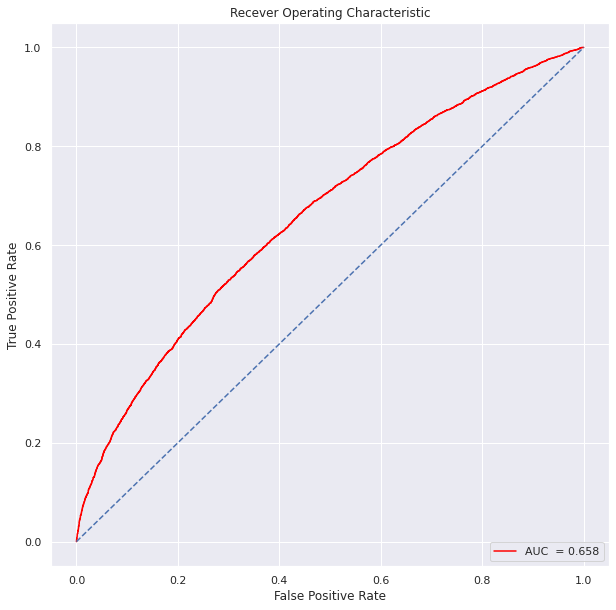

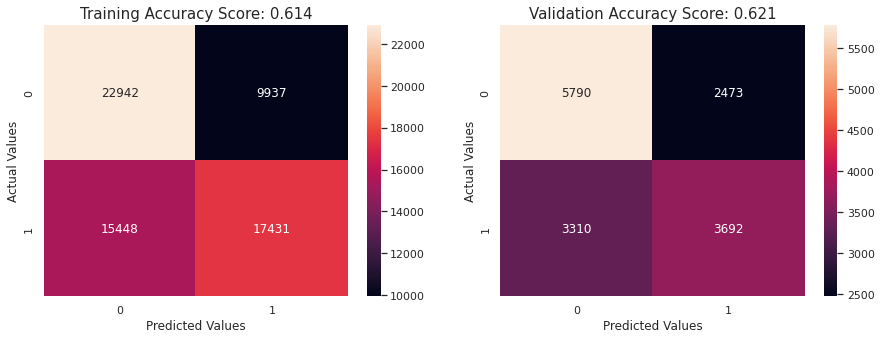

In [36]:
lr=LogisticRegression(random_state = 42, solver = 'newton-cg', max_iter = 200)
lr.fit(X_train, y_train)

y_train_preds = lr.predict_proba(X_train)[:,1]
y_valid_preds = lr.predict_proba(X_valid)[:,1]

print('Logistic Regression')
print('Metrics for Training:')
lr_train_auc, lr_train_accuracy, lr_train_recall, \
    lr_train_precision, lr_train_fscore, lr_train_specificity = print_report(y_train,y_train_preds, thresh)

print('Metrics for Validation:')
lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_val_fscore, lr_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_valid, y_valid_preds)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(f'The roc_auc is: {round(roc_auc*100,3)}%')
plot_roc(roc_auc)

predictions = lr.predict(X_train)
train_score = round(accuracy_score(y_train, predictions), 3)
cm_train = confusion_matrix(y_train, predictions)

predictions = lr.predict(X_valid)
val_score = round(accuracy_score(y_valid, predictions), 3)
cm_val = confusion_matrix(y_valid, predictions)

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(15,5)) 
sns.heatmap(cm_train, annot=True, fmt=".0f",ax=ax1)
ax1.set_xlabel('Predicted Values')
ax1.set_ylabel('Actual Values')
ax1.set_title('Training Accuracy Score: {0}'.format(train_score), size = 15)
sns.heatmap(cm_val, annot=True, fmt=".0f",ax=ax2)
ax2.set_xlabel('Predicted Values')
ax2.set_ylabel('Actual Values')
ax2.set_title('Validation Accuracy Score: {0}'.format(val_score), size = 15)
plt.show()

### KNN

KNN
Metrics for Training:
AUC: 0.660
accuracy: 0.610
recall: 0.561
precision: 0.621
fscore: 0.590
specificity: 0.620
prevalence: 0.500
 
Metrics for Validation:
AUC: 0.632
accuracy: 0.596
recall: 0.548
precision: 0.561
fscore: 0.555
specificity: 0.601
prevalence: 0.459
 
The roc_auc is: 63.17%


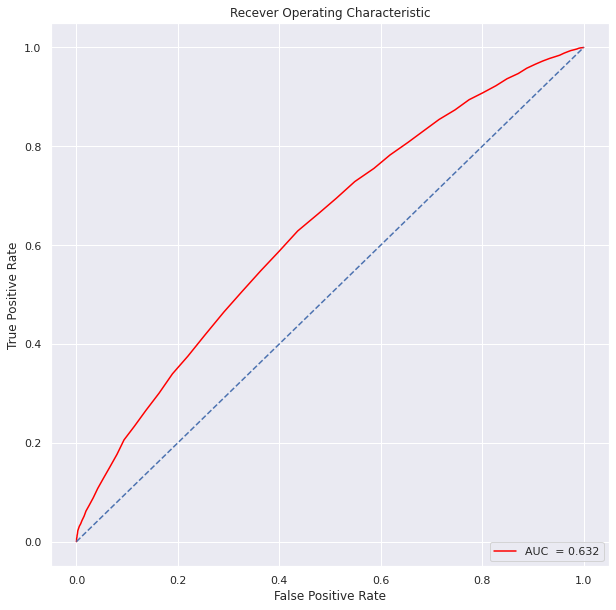

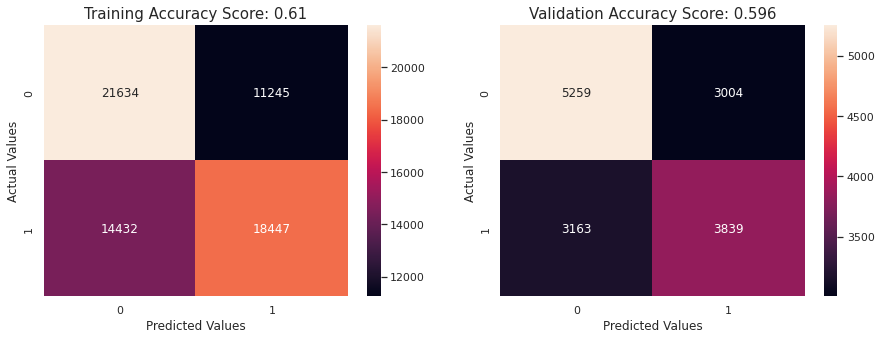

In [37]:
knn = KNeighborsClassifier(n_neighbors = 100)
# default n_jobs = None
knn.fit(X_train, y_train)

y_train_preds = knn.predict_proba(X_train)[:,1]
y_valid_preds = knn.predict_proba(X_valid)[:,1]

print('KNN')
print('Metrics for Training:')
knn_train_auc, knn_train_accuracy, knn_train_recall, \
    knn_train_precision, knn_train_fscore, knn_train_specificity = print_report(y_train,y_train_preds, thresh)

print('Metrics for Validation:')
knn_valid_auc, knn_valid_accuracy, knn_valid_recall, \
    knn_valid_precision, knn_val_fscore, knn_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_valid, y_valid_preds)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(f'The roc_auc is: {round(roc_auc*100,3)}%')
plot_roc(roc_auc)

predictions = knn.predict(X_train)
train_score = round(accuracy_score(y_train, predictions), 3)
cm_train = confusion_matrix(y_train, predictions)

predictions = knn.predict(X_valid)
val_score = round(accuracy_score(y_valid, predictions), 3)
cm_val = confusion_matrix(y_valid, predictions)

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(15,5)) 
sns.heatmap(cm_train, annot=True, fmt=".0f",ax=ax1)
ax1.set_xlabel('Predicted Values')
ax1.set_ylabel('Actual Values')
ax1.set_title('Training Accuracy Score: {0}'.format(train_score), size = 15)
sns.heatmap(cm_val, annot=True, fmt=".0f",ax=ax2)
ax2.set_xlabel('Predicted Values')
ax2.set_ylabel('Actual Values')
ax2.set_title('Validation Accuracy Score: {0}'.format(val_score), size = 15)
plt.show()

### Stochastic Gradient Descent

Stochastic Gradient Descent
Metrics for Training:
AUC: 0.649
accuracy: 0.603
recall: 0.635
precision: 0.597
fscore: 0.615
specificity: 0.572
prevalence: 0.500
 
Metrics for Validation:
AUC: 0.651
accuracy: 0.602
recall: 0.636
precision: 0.559
fscore: 0.595
specificity: 0.574
prevalence: 0.459
 
The roc_auc is: 65.144%


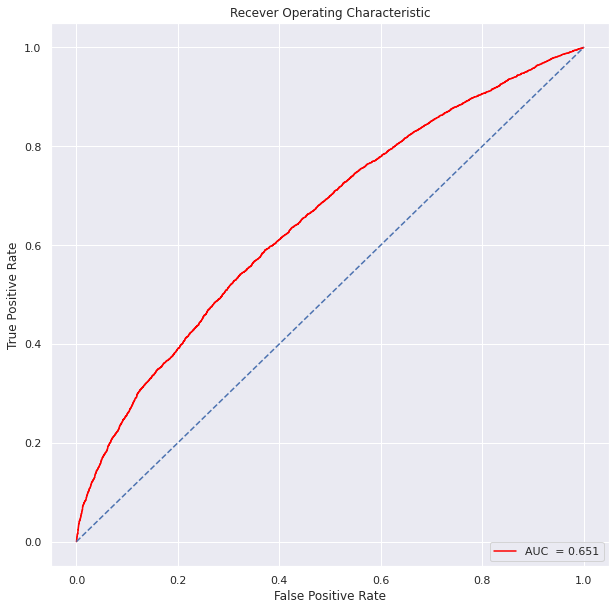

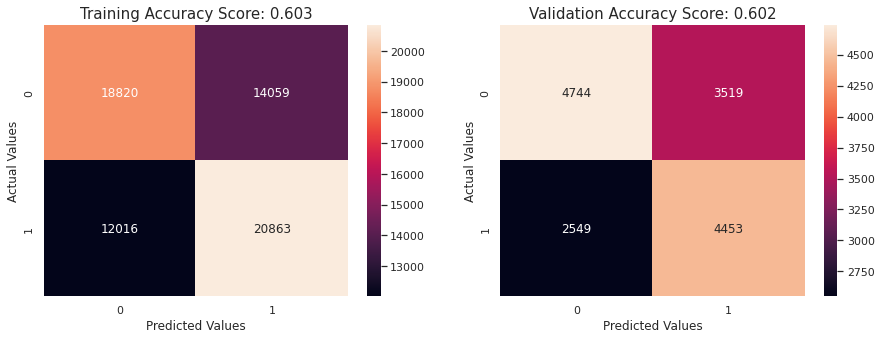

In [38]:
sgdc=SGDClassifier(loss = 'log',alpha = 0.1,random_state = 42)
sgdc.fit(X_train, y_train)

y_train_preds = sgdc.predict_proba(X_train)[:,1]
y_valid_preds = sgdc.predict_proba(X_valid)[:,1]

print('Stochastic Gradient Descent')
print('Metrics for Training:')
sgdc_train_auc, sgdc_train_accuracy, sgdc_train_recall, \
    sgdc_train_precision, sgdc_train_fscore, sgdc_train_specificity = print_report(y_train,y_train_preds, thresh)

print('Metrics for Validation:')
sgdc_valid_auc, sgdc_valid_accuracy, sgdc_valid_recall, \
     sgdc_valid_precision, sgdc_valid_fscore, sgdc_valid_specificity = print_report(y_valid,y_valid_preds, thresh)


false_positive_rate, true_positive_rate, thresholds = roc_curve(y_valid, y_valid_preds)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(f'The roc_auc is: {round(roc_auc*100,3)}%')
plot_roc(roc_auc)

predictions = sgdc.predict(X_train)
train_score = round(accuracy_score(y_train, predictions), 3)
cm_train = confusion_matrix(y_train, predictions)

predictions = sgdc.predict(X_valid)
val_score = round(accuracy_score(y_valid, predictions), 3)
cm_val = confusion_matrix(y_valid, predictions)

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(15,5)) 
sns.heatmap(cm_train, annot=True, fmt=".0f",ax=ax1)
ax1.set_xlabel('Predicted Values')
ax1.set_ylabel('Actual Values')
ax1.set_title('Training Accuracy Score: {0}'.format(train_score), size = 15)
sns.heatmap(cm_val, annot=True, fmt=".0f",ax=ax2)
ax2.set_xlabel('Predicted Values')
ax2.set_ylabel('Actual Values')
ax2.set_title('Validation Accuracy Score: {0}'.format(val_score), size = 15)
plt.show()

### Decision Tree

Decision Tree
Metrics for Training:
AUC: 0.720
accuracy: 0.654
recall: 0.643
precision: 0.658
fscore: 0.650
specificity: 0.664
prevalence: 0.500
 
Metrics for Validation:
AUC: 0.667
accuracy: 0.621
recall: 0.612
precision: 0.583
fscore: 0.597
specificity: 0.626
prevalence: 0.459
 
The roc_auc is: 66.743%


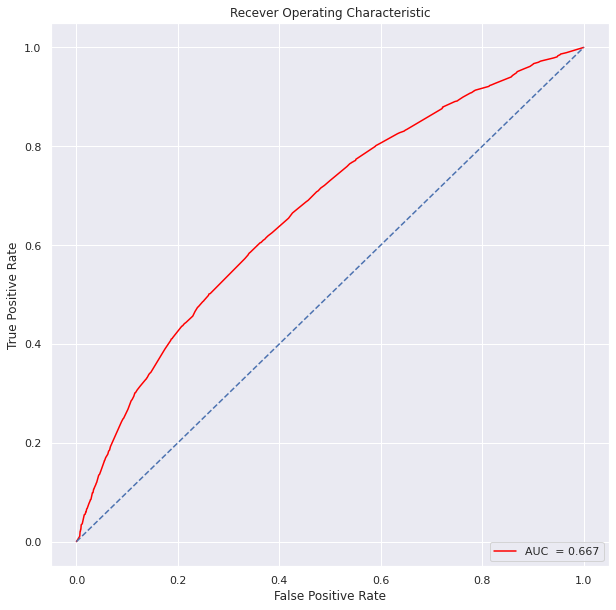

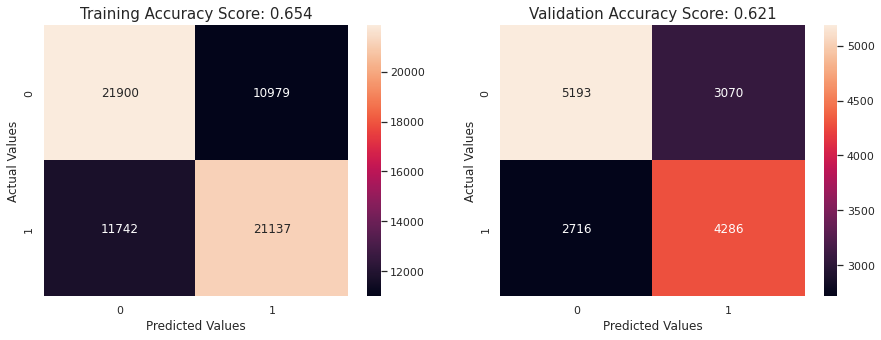

In [39]:
dc_clf = DecisionTreeClassifier(random_state=42, max_depth = 10)
dc_clf.fit(X_train, y_train)

y_train_preds = dc_clf.predict_proba(X_train)[:,1]
y_valid_preds = dc_clf.predict_proba(X_valid)[:,1]

print('Decision Tree')
print('Metrics for Training:')
dc_clf_train_auc, dc_clf_train_accuracy, dc_clf_train_recall, \
    dc_clf_train_precision, dc_clf_train_fscore, dc_clf_train_specificity = print_report(y_train,y_train_preds, thresh)

print('Metrics for Validation:')
dc_clf_valid_auc, dc_clf_valid_accuracy, dc_clf_valid_recall, \
                dc_clf_valid_precision, dc_clf_train_fscore, sgdc_valid_specificity = print_report(y_valid,y_valid_preds, thresh)


false_positive_rate, true_positive_rate, thresholds = roc_curve(y_valid, y_valid_preds)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(f'The roc_auc is: {round(roc_auc*100,3)}%')
plot_roc(roc_auc)

predictions = dc_clf.predict(X_train)
train_score = round(accuracy_score(y_train, predictions), 3)
cm_train = confusion_matrix(y_train, predictions)

predictions = dc_clf.predict(X_valid)
val_score = round(accuracy_score(y_valid, predictions), 3)
cm_val = confusion_matrix(y_valid, predictions)

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(15,5)) 
sns.heatmap(cm_train, annot=True, fmt=".0f",ax=ax1)
ax1.set_xlabel('Predicted Values')
ax1.set_ylabel('Actual Values')
ax1.set_title('Training Accuracy Score: {0}'.format(train_score), size = 15)
sns.heatmap(cm_val, annot=True, fmt=".0f",ax=ax2)
ax2.set_xlabel('Predicted Values')
ax2.set_ylabel('Actual Values')
ax2.set_title('Validation Accuracy Score: {0}'.format(val_score), size = 15)
plt.show()

### Linear SVC

Linear SVC
Metrics for Training:
AUC: 0.558
accuracy: 0.506
recall: 0.016
precision: 0.826
fscore: 0.031
specificity: 0.997
prevalence: 0.500
 
Metrics for Validation:
AUC: 0.557
accuracy: 0.548
recall: 0.020
precision: 0.817
fscore: 0.038
specificity: 0.996
prevalence: 0.459
 
The roc_auc is: 55.716%


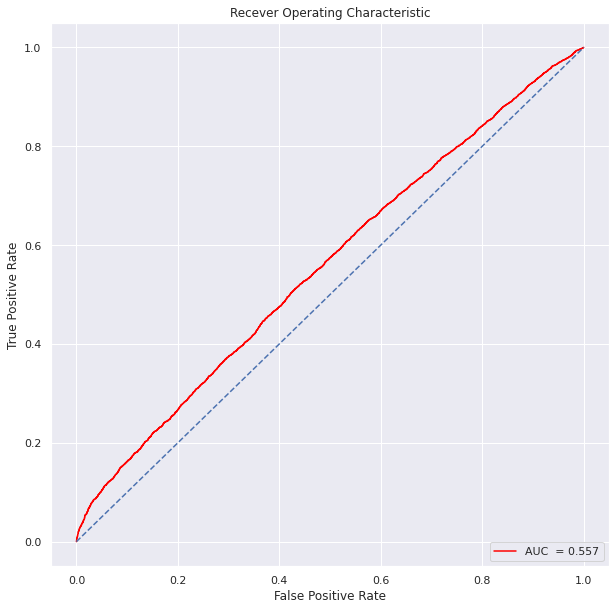

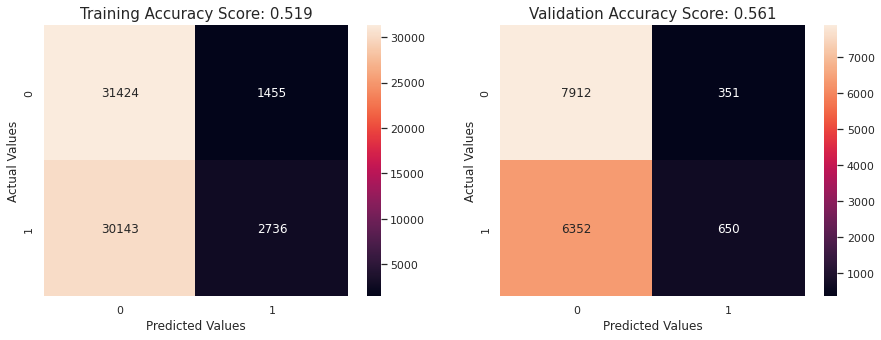

In [40]:
lsvc_clf = LinearSVC(random_state=111)
lsvc_clf.fit(X_train, y_train)

y_train_preds = lsvc_clf.decision_function(X_train)
y_valid_preds = lsvc_clf.decision_function(X_valid)

print('Linear SVC')
print('Metrics for Training:')
lsvc_clf_train_auc, lsvc_clf_train_accuracy, lsvc_clf_train_recall, \
    lsvc_clf_train_precision, lsvc_clf_train_fscore, lsvc_clf_train_specificity = print_report(y_train,y_train_preds, thresh)

print('Metrics for Validation:')
lsvc_clf_valid_auc, lsvc_clf_valid_accuracy, lsvc_clf_valid_recall, \
                lsvc_clf_valid_precision, lsvc_clf_train_fscore, lsvc_clf_valid_specificity = print_report(y_valid,y_valid_preds, thresh)


false_positive_rate, true_positive_rate, thresholds = roc_curve(y_valid, y_valid_preds)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(f'The roc_auc is: {round(roc_auc*100,3)}%')
plot_roc(roc_auc)

predictions = lsvc_clf.predict(X_train)
train_score = round(accuracy_score(y_train, predictions), 3)
cm_train = confusion_matrix(y_train, predictions)

predictions = lsvc_clf.predict(X_valid)
val_score = round(accuracy_score(y_valid, predictions), 3)
cm_val = confusion_matrix(y_valid, predictions)

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(15,5)) 
sns.heatmap(cm_train, annot=True, fmt=".0f",ax=ax1)
ax1.set_xlabel('Predicted Values')
ax1.set_ylabel('Actual Values')
ax1.set_title('Training Accuracy Score: {0}'.format(train_score), size = 15)
sns.heatmap(cm_val, annot=True, fmt=".0f",ax=ax2)
ax2.set_xlabel('Predicted Values')
ax2.set_ylabel('Actual Values')
ax2.set_title('Validation Accuracy Score: {0}'.format(val_score), size = 15)
plt.show()

### Random Forest

Random Forest
Metrics for Training:
AUC: 0.686
accuracy: 0.635
recall: 0.591
precision: 0.648
fscore: 0.618
specificity: 0.679
prevalence: 0.500
 
Metrics for Validation:
AUC: 0.676
accuracy: 0.630
recall: 0.582
precision: 0.600
fscore: 0.591
specificity: 0.671
prevalence: 0.459
 
The roc_auc is: 67.604%


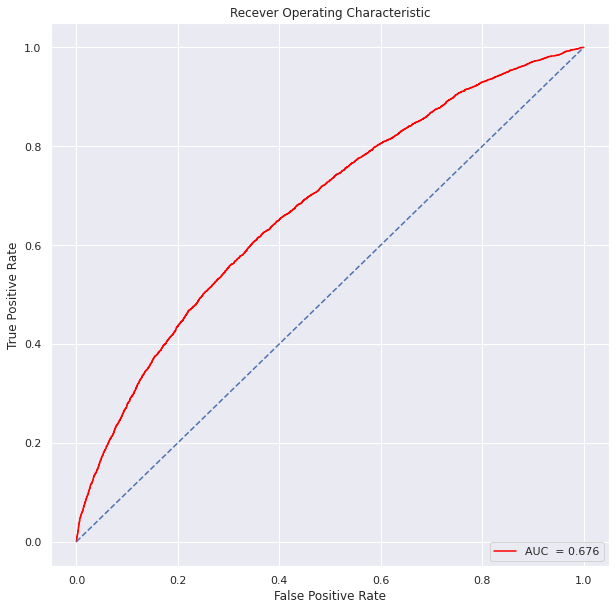

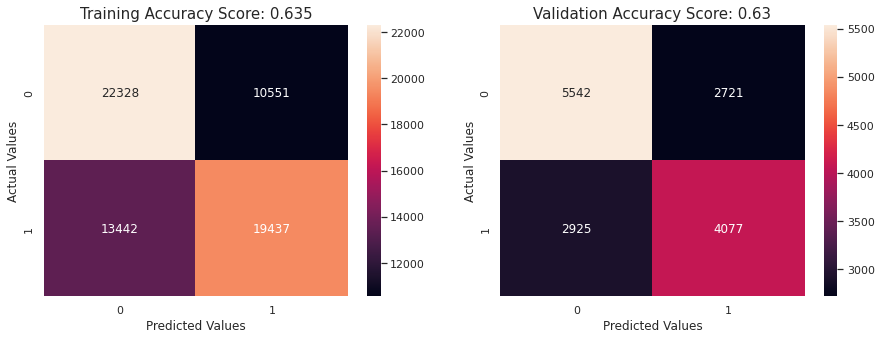

In [41]:
rf_clf = RandomForestClassifier(random_state=111, max_depth = 6)
rf_clf.fit(X_train, y_train)

y_train_preds = rf_clf.predict_proba(X_train)[:,1]
y_valid_preds = rf_clf.predict_proba(X_valid)[:,1]

print('Random Forest')
print('Metrics for Training:')
rf_clf_train_auc, rf_clf_train_accuracy, rf_clf_train_recall, \
    rf_clf_train_precision, rf_clf_train_fscore, rf_clf_train_specificity = print_report(y_train,y_train_preds, thresh)

print('Metrics for Validation:')
rf_clf_valid_auc, drf_clf_valid_accuracy, rf_clf_valid_recall, \
                rf_clf_valid_precision, rf_clf_train_fscore, rf_clf_valid_specificity = print_report(y_valid,y_valid_preds, thresh)


false_positive_rate, true_positive_rate, thresholds = roc_curve(y_valid, y_valid_preds)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(f'The roc_auc is: {round(roc_auc*100,3)}%')
plot_roc(roc_auc)

predictions = rf_clf.predict(X_train)
train_score = round(accuracy_score(y_train, predictions), 3)
cm_train = confusion_matrix(y_train, predictions)

predictions = rf_clf.predict(X_valid)
val_score = round(accuracy_score(y_valid, predictions), 3)
cm_val = confusion_matrix(y_valid, predictions)

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(15,5)) 
sns.heatmap(cm_train, annot=True, fmt=".0f",ax=ax1)
ax1.set_xlabel('Predicted Values')
ax1.set_ylabel('Actual Values')
ax1.set_title('Training Accuracy Score: {0}'.format(train_score), size = 15)
sns.heatmap(cm_val, annot=True, fmt=".0f",ax=ax2)
ax2.set_xlabel('Predicted Values')
ax2.set_ylabel('Actual Values')
ax2.set_title('Validation Accuracy Score: {0}'.format(val_score), size = 15)
plt.show()

### Gradient Boost

Gradient Boosting
Metrics for Training:
AUC: 0.729
accuracy: 0.663
recall: 0.658
precision: 0.665
fscore: 0.661
specificity: 0.668
prevalence: 0.500
 
Metrics for Validation:
AUC: 0.682
accuracy: 0.632
recall: 0.624
precision: 0.594
fscore: 0.609
specificity: 0.638
prevalence: 0.459
 
The roc_auc is: 68.177%


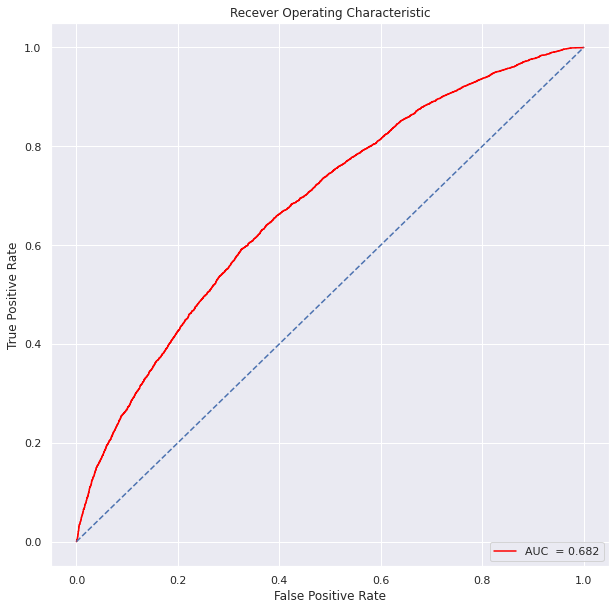

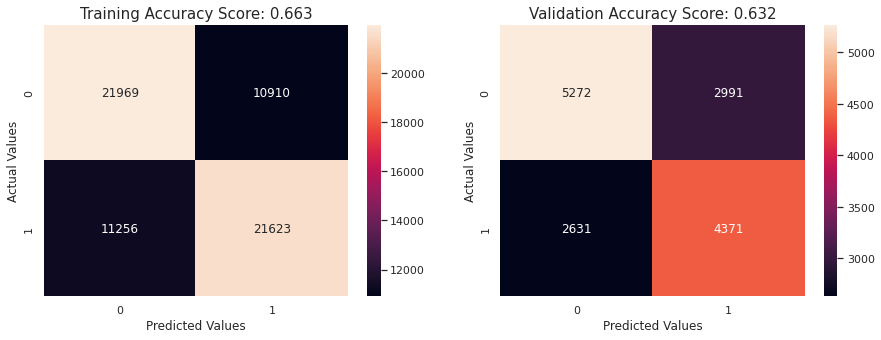

In [42]:
gb_clf = GradientBoostingClassifier(n_estimators = 100, criterion='friedman_mse', learning_rate = 1.0, max_depth = 3, random_state = 111)
gb_clf.fit(X_train, y_train)

y_train_preds = gb_clf.predict_proba(X_train)[:,1]
y_valid_preds = gb_clf.predict_proba(X_valid)[:,1]

print('Gradient Boosting')
print('Metrics for Training:')
lsvc_clf_train_auc, lsvc_clf_train_accuracy, lsvc_clf_train_recall, \
    lsvc_clf_train_precision, lsvc_clf_train_fscore, lsvc_clf_train_specificity = print_report(y_train,y_train_preds, thresh)

print('Metrics for Validation:')
lsvc_clf_valid_auc, lsvc_clf_valid_accuracy, lsvc_clf_valid_recall, \
                lsvc_clf_valid_precision, lsvc_clf_train_fscore, lsvc_clf_valid_specificity = print_report(y_valid,y_valid_preds, thresh)


false_positive_rate, true_positive_rate, thresholds = roc_curve(y_valid, y_valid_preds)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(f'The roc_auc is: {round(roc_auc*100,3)}%')
plot_roc(roc_auc)

predictions = gb_clf.predict(X_train)
train_score = round(accuracy_score(y_train, predictions), 3)
cm_train = confusion_matrix(y_train, predictions)

predictions = gb_clf.predict(X_valid)
val_score = round(accuracy_score(y_valid, predictions), 3)
cm_val = confusion_matrix(y_valid, predictions)

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(15,5)) 
sns.heatmap(cm_train, annot=True, fmt=".0f",ax=ax1)
ax1.set_xlabel('Predicted Values')
ax1.set_ylabel('Actual Values')
ax1.set_title('Training Accuracy Score: {0}'.format(train_score), size = 15)
sns.heatmap(cm_val, annot=True, fmt=".0f",ax=ax2)
ax2.set_xlabel('Predicted Values')
ax2.set_ylabel('Actual Values')
ax2.set_title('Validation Accuracy Score: {0}'.format(val_score), size = 15)
plt.show()

### XGBoost

Gradient Boosting
Metrics for Training:
AUC: 0.729
accuracy: 0.662
recall: 0.660
precision: 0.663
fscore: 0.661
specificity: 0.664
prevalence: 0.500
 
Metrics for Validation:
AUC: 0.687
accuracy: 0.632
recall: 0.625
precision: 0.593
fscore: 0.609
specificity: 0.637
prevalence: 0.459
 
The roc_auc is: 68.684%


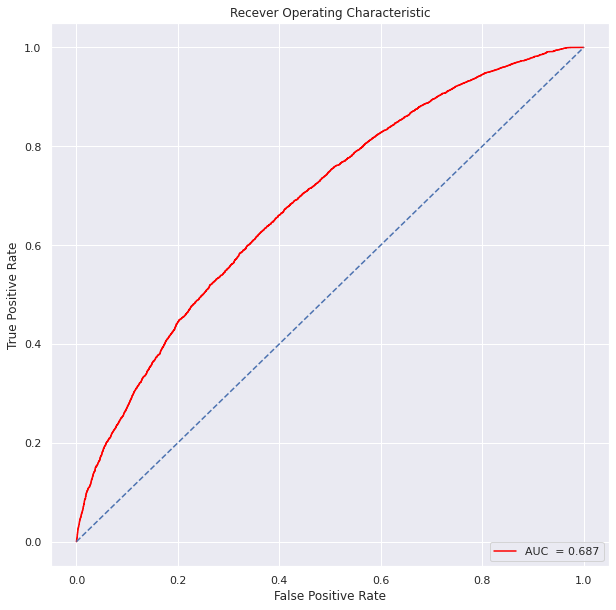

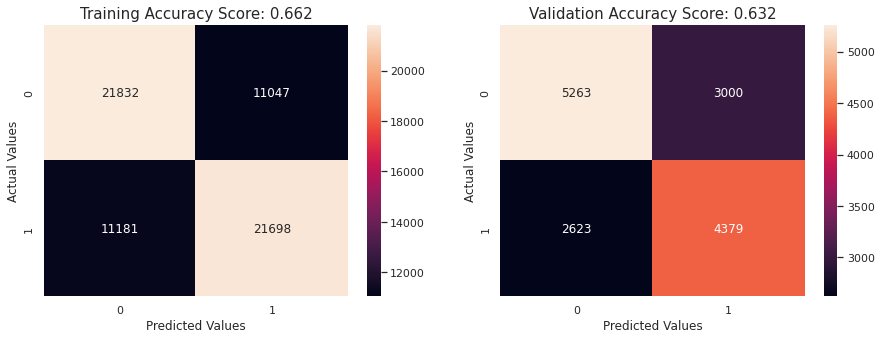

In [43]:
xgb_clf = xgb.XGBClassifier(max_depth=3, learning_rate = 1.0, use_label_encoder = False,\
                            eval_metric = 'logloss')
xgb_clf.fit(X_train, y_train)

y_train_preds = xgb_clf.predict_proba(X_train)[:,1]
y_valid_preds = xgb_clf.predict_proba(X_valid)[:,1]

print('XGBoosting')
print('Metrics for Training:')
lsvc_clf_train_auc, lsvc_clf_train_accuracy, lsvc_clf_train_recall, \
    lsvc_clf_train_precision, lsvc_clf_train_fscore, lsvc_clf_train_specificity = print_report(y_train,y_train_preds, thresh)

print('Metrics for Validation:')
lsvc_clf_valid_auc, lsvc_clf_valid_accuracy, lsvc_clf_valid_recall, \
                lsvc_clf_valid_precision, lsvc_clf_train_fscore, lsvc_clf_valid_specificity = print_report(y_valid,y_valid_preds, thresh)


false_positive_rate, true_positive_rate, thresholds = roc_curve(y_valid, y_valid_preds)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(f'The roc_auc is: {round(roc_auc*100,3)}%')
plot_roc(roc_auc)

predictions = xgb_clf.predict(X_train)
train_score = round(accuracy_score(y_train, predictions), 3)
cm_train = confusion_matrix(y_train, predictions)

predictions = xgb_clf.predict(X_valid)
val_score = round(accuracy_score(y_valid, predictions), 3)
cm_val = confusion_matrix(y_valid, predictions)

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(15,5)) 
sns.heatmap(cm_train, annot=True, fmt=".0f",ax=ax1)
ax1.set_xlabel('Predicted Values')
ax1.set_ylabel('Actual Values')
ax1.set_title('Training Accuracy Score: {0}'.format(train_score), size = 15)
sns.heatmap(cm_val, annot=True, fmt=".0f",ax=ax2)
ax2.set_xlabel('Predicted Values')
ax2.set_ylabel('Actual Values')
ax2.set_title('Validation Accuracy Score: {0}'.format(val_score), size = 15)
plt.show()

### Catboost 

0:	learn: 0.6615292	total: 61.7ms	remaining: 12.3s
1:	learn: 0.6489962	total: 74.4ms	remaining: 7.36s
2:	learn: 0.6437672	total: 90.2ms	remaining: 5.92s
3:	learn: 0.6402330	total: 100ms	remaining: 4.91s
4:	learn: 0.6385276	total: 110ms	remaining: 4.29s
5:	learn: 0.6373825	total: 119ms	remaining: 3.84s
6:	learn: 0.6358433	total: 129ms	remaining: 3.57s
7:	learn: 0.6347482	total: 139ms	remaining: 3.35s
8:	learn: 0.6341067	total: 149ms	remaining: 3.17s
9:	learn: 0.6334294	total: 158ms	remaining: 3.01s
10:	learn: 0.6327422	total: 169ms	remaining: 2.9s
11:	learn: 0.6322978	total: 178ms	remaining: 2.79s
12:	learn: 0.6316211	total: 187ms	remaining: 2.69s
13:	learn: 0.6311376	total: 198ms	remaining: 2.63s
14:	learn: 0.6307825	total: 210ms	remaining: 2.58s
15:	learn: 0.6303310	total: 219ms	remaining: 2.52s
16:	learn: 0.6298397	total: 229ms	remaining: 2.46s
17:	learn: 0.6294020	total: 238ms	remaining: 2.41s
18:	learn: 0.6291654	total: 250ms	remaining: 2.38s
19:	learn: 0.6285719	total: 265ms	remai

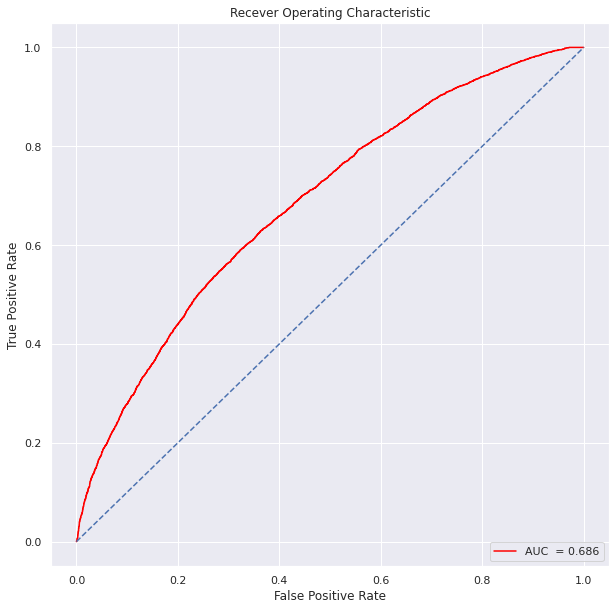

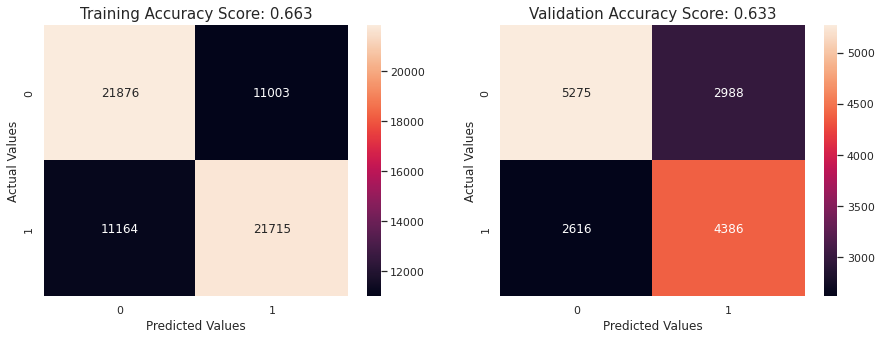

In [44]:
catb = CatBoostClassifier(iterations=200, depth=3, learning_rate=1.0, random_state = 111)
catb.fit(X_train, y_train)

y_train_preds = catb.predict_proba(X_train)[:,1]
y_valid_preds = catb.predict_proba(X_valid)[:,1]

print('Catboost')
print('Metrics for Training:')
lsvc_clf_train_auc, lsvc_clf_train_accuracy, lsvc_clf_train_recall, \
    lsvc_clf_train_precision, lsvc_clf_train_fscore, lsvc_clf_train_specificity = print_report(y_train,y_train_preds, thresh)

print('Metrics for Validation:')
lsvc_clf_valid_auc, lsvc_clf_valid_accuracy, lsvc_clf_valid_recall, \
                lsvc_clf_valid_precision, lsvc_clf_train_fscore, lsvc_clf_valid_specificity = print_report(y_valid,y_valid_preds, thresh)


false_positive_rate, true_positive_rate, thresholds = roc_curve(y_valid, y_valid_preds)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(f'The roc_auc is: {round(roc_auc*100,3)}%')
plot_roc(roc_auc)

predictions = catb.predict(X_train)
train_score = round(accuracy_score(y_train, predictions), 3)
cm_train = confusion_matrix(y_train, predictions)

predictions = catb.predict(X_valid)
val_score = round(accuracy_score(y_valid, predictions), 3)
cm_val = confusion_matrix(y_valid, predictions)

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(15,5)) 
sns.heatmap(cm_train, annot=True, fmt=".0f",ax=ax1)
ax1.set_xlabel('Predicted Values')
ax1.set_ylabel('Actual Values')
ax1.set_title('Training Accuracy Score: {0}'.format(train_score), size = 15)
sns.heatmap(cm_val, annot=True, fmt=".0f",ax=ax2)
ax2.set_xlabel('Predicted Values')
ax2.set_ylabel('Actual Values')
ax2.set_title('Validation Accuracy Score: {0}'.format(val_score), size = 15)
plt.show()

## Hyper-parameter tuning

In [45]:
recall_scoring = make_scorer(recall_score)

### Decision Tree Tuning

In [46]:
dc_grid = {'max_features':['auto','sqrt'], # maximum number of features to use at each split
           'max_depth':range(1,11,1), # maximum depth of the tree
           'min_samples_split':range(2,10,2), # minimum number of samples to split a node
           'criterion':['gini','entropy']} # criterion for evaluating a split

dc_random = RandomizedSearchCV(estimator = dc_clf, param_distributions = dc_grid, 
                               n_iter = 20, cv = 2, scoring=recall_scoring,
                               verbose = 1, random_state = 111)

dc_random.fit(X_train, y_train)

dc_random.best_params_

#y_train_preds = dc_random.predict_proba(X_train)[:,1]
y_valid_preds = dc_random.predict_proba(X_valid)[:,1]
dc_hp_preds = dc_random.best_estimator_.predict(X_valid)

print(f'AUC: {round(roc_auc_score(y_valid, y_valid_preds)*100,3)}%')
print(f'Recall: {round(recall_score(y_valid, dc_hp_preds)*100,3)}%')

Fitting 2 folds for each of 20 candidates, totalling 40 fits
AUC: 52.487%
Recall: 79.22%


In [65]:
dc_grid = {'max_features':['auto','sqrt'], # maximum number of features to use at each split
           'max_depth':range(1,11,1), # maximum depth of the tree
           'min_samples_split':range(2,10,2), # minimum number of samples to split a node
           'criterion':['gini','entropy']} # criterion for evaluating a split

dc_random = RandomizedSearchCV(estimator = dc_clf, param_distributions = dc_grid, 
                               n_iter = 20, cv = 2, scoring=recall_scoring,
                               verbose = 1, random_state = 111)

dc_random.fit(X_train, y_train)

dc_random.best_params_

dc_hp_preds = dc_random.best_estimator_.predict(X_valid)
dc_hp_preds_proba = dc_random.best_estimator_.predict_proba(X_valid)[:,1]

#y_train_preds = dc_random.predict_proba(X_train)[:,1]
#y_valid_preds = dc_random.predict_proba(X_valid)[:,1]


print(f'AUC: {round(roc_auc_score(y_valid, dc_hp_preds_proba)*100,3)}%')
print(f'Recall: {round(recall_score(y_valid, dc_hp_preds)*100,3)}%')

Fitting 2 folds for each of 20 candidates, totalling 40 fits
AUC: 52.487%
Recall: 79.22%


In [ ]:
y_train_preds = random_forest_model.predict_proba(X_train)[:,1]
y_val_preds = random_forest_model.predict_proba(X_val)[:,1]

print('Baseline Random Forest')
rf_train_auc_base = roc_auc_score(y_train, y_train_preds)
rf_val_auc_base = roc_auc_score(y_val, y_val_preds)

print('Training AUC:%.3f'%(rf_train_auc_base))
print('Validation AUC:%.3f'%(rf_val_auc_base))

### Random Forest Tuning

In [70]:
rf_grid = {'n_estimators':range(200,1000,200), # number of trees
           'max_features':['auto','sqrt'], # maximum number of features to use at each split
           'max_depth':range(1,11,1), # maximum depth of the tree
           'min_samples_split':range(2,10,2), # minimum number of samples to split a node
           'criterion':['gini','entropy']} # criterion for evaluating a split

rf_random = RandomizedSearchCV(estimator = rf_clf, param_distributions = rf_grid, 
                               n_iter = 20, cv = 2, scoring=recall_scoring,
                               verbose = 1, random_state = 111)

rf_random.fit(X_train, y_train)

rf_random.best_params_

rf_hp_preds = rf_random.best_estimator_.predict(X_valid)
rf_hp_preds_proba = rf_random.best_estimator_.predict_proba(X_valid)[:,1]


print(f'AUC: {round(roc_auc_score(y_valid, rf_hp_preds_proba)*100,3)}%')
print(f'Recall: {round(recall_score(y_valid, rf_hp_preds)*100,3)}%')

Fitting 2 folds for each of 20 candidates, totalling 40 fits
AUC: 68.08%
Recall: 59.626%


### XGBoost Tuning

In [ ]:
xgb_grid = params = {
        'min_child_weight': [1, 5, 8, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 0.9, 1.0],
        'max_depth': [3, 4, 5]
        } # criterion for evaluating a split

xgb_random = GridSearchCV(estimator = xgb_clf, param_grid = xgb_grid, 
                               cv = 2, scoring = recall_scoring,
                               verbose = 1)

xgb_random.fit(X_train, y_train)

xgb_random.best_params_

xgb_hp_preds = xgb_random.best_estimator_.predict(X_valid)
xgb_hp_preds_proba = xgb_random.best_estimator_.predict_proba(X_valid)[:,1]


print(f'AUC: {round(roc_auc_score(y_valid, xgb_hp_preds_proba)*100,3)}%')
print(f'Recall: {round(recall_score(y_valid, xgb_hp_preds)*100,3)}%')

Fitting 2 folds for each of 720 candidates, totalling 1440 fits


### Catboost Tuning

In [ ]:
catb_params={"iterations":[200,500,1000],
            "learning_rate":[0.05,0.1],
            "depth":[4,5,8]}

catb_cv_model=GridSearchCV(catb,catb_params, cv=3, n_jobs=-1,  verbose=2).fit(X_train_importance,y_train)

catb_params={"iterations":[200,500,1000],
            "learning_rate":[0.05,0.1],
            "depth":[4,5,8]} 

catb_cv_model=GridSearchCV(catb,catb_params, cv=3, n_jobs=-1,  verbose=2).fit(X_train_importance,y_train)    

y_train_preds = cat_model.predict_proba(X_train)[:,1]
y_valid_preds = cat_model.predict_proba(X_val)[:,1]

print('Baseline CATBOOST')
catb_train_auc_base = roc_auc_score(y_train, y_train_preds)
catb_val_auc_base = roc_auc_score(y_val, y_val_preds)

print('Training AUC:%.3f'%(catb_train_auc_base))
print('Validation AUC:%.3f'%(catb_val_auc_base))